# Code for Monkey reaching experiment 

## Learned embeddings uploaded in, along with the training scripts in. 
## Methods: ISED, PCA, t-SNE, UMAP and Cebra-time
## Reproduce Fig 4.(B)-(D) in the main text 
## Extended Data Fig. 4(D), Supplementary Results C, Supplementary Fig. 9-10.


In [1]:
import cebra.datasets


monkey_pos_all = cebra.datasets.init('area2-bump-pos-active-passive')
monkey_target_all = cebra.datasets.init('area2-bump-target-active-passive')

## All data are equal across two datasets; but caution on .neural != ['spikes']

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

def post_hoc_smoothing(data, filter_type='savitzky_golay', window_size=11, polynomial_order=5, sigma=5):
    """
    Applies post-hoc smoothing to a multivariate time series.

    Args:
        data (pd.DataFrame or np.ndarray): The multivariate time series data,
                                            with time as rows and variables as columns.
        filter_type (str, optional): The type of filter to use.
                                     Options: 'moving_average', 'gaussian', 'savitzky_golay'.
                                     Defaults to 'gaussian'.
        window_size (int, optional): The size of the window for the moving average and
                                   Savitzky-Golay filters. Must be an odd integer.
                                   Defaults to 11.
        polynomial_order (int, optional): The order of the polynomial for the
                                          Savitzky-Golay filter. Must be less than window_size.
                                          Defaults to 3.
        sigma (float, optional): The standard deviation for the Gaussian filter.
                                 Defaults to 3.

    Returns:
        pd.DataFrame or np.ndarray: The smoothed multivariate time series,
                                    in the same format as the input data.
    """
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise TypeError("Input data must be a pandas DataFrame or a NumPy array.")

    if window_size % 2 == 0:
        raise ValueError("window_size must be an odd integer.")

    is_pandas = isinstance(data, pd.DataFrame)
    if is_pandas:
        original_index = data.index
        original_columns = data.columns
        data_np = data.values
    else:
        data_np = data

    smoothed_data = np.zeros_like(data_np)

    for i in range(data_np.shape[1]):
        if filter_type == 'moving_average':
            # Using pandas rolling mean for simplicity and to handle edges well
            series = pd.Series(data_np[:, i])
            smoothed_data[:, i] = series.rolling(window=window_size, center=True, min_periods=1).mean()
        elif filter_type == 'gaussian':
            smoothed_data[:, i] = gaussian_filter1d(data_np[:, i], sigma=sigma)
        elif filter_type == 'savitzky_golay':
            if polynomial_order >= window_size:
                raise ValueError("polynomial_order must be less than window_size.")
            smoothed_data[:, i] = savgol_filter(data_np[:, i], window_length=window_size, polyorder=polynomial_order)
        else:
            raise ValueError("Invalid filter_type. Choose from 'moving_average', 'gaussian', or 'savitzky_golay'.")

    if is_pandas:
        return pd.DataFrame(smoothed_data, index=original_index, columns=original_columns)
    else:
        return smoothed_data

def compute_smoothness(data):
    diff = np.diff(data, axis=0)
    bending_energy = np.sum(np.linalg.norm(diff, axis=1)**2)  ## conventional 1-degree time difference
    if bending_energy < 1e-9:
        # For a perfectly smooth (constant) signal, return a large, finite number
        return 1e20  # Represents a very high smoothness score
    else:
        return 1 / bending_energy


In [3]:
passive = monkey_target_all.data['passive']
active_mask  = (passive == 0)
passive_mask = (passive == 1)


In [4]:
ised_embeddings = np.load('maze_ised_trial_wise_2.npy')
ised_embeddings.shape

(364, 600, 2)

In [602]:
## Randomly picked original 
ori = np.array(monkey_pos_all.neural).reshape((364, 600, 65))
np.random.seed(42)
dims = np.random.choice(65, size=2, replace=False)
ori = ori[:,:,dims]
np.save('ori_monkey_dim_2.npy', ori)


In [7]:
import pickle


target_embeddings = {
    #'ori': 'ori_monkey_dim_2.npy',
    'ised':'maze_ised_trial_wise_2.npy',
    'tsne': 'tsne_embeddings_pos.npy',
    'umap':'umap_embeddings_pos.npy',
    'pca': 'pca_embeddings_pos.npy',
    'cebra':'cebra_embeddings_pos_timemodel.npy'


}

In [8]:
# List to store information about problematic trials

def compute_smoothness_detailed(data):
    """
    Calculates smoothness and also returns the raw bending energy for inspection.
    """
    diff = np.diff(data, axis=0)
    bending_energy = np.sum(np.linalg.norm(diff, axis=1)**2)
 
    smoothness_score = 1 / bending_energy
        
    return smoothness_score, bending_energy
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# List to store information about any problematic trials found
problematic_trials = []

# Define your threshold for high energy. You may need to adjust this value.
ENERGY_THRESHOLD = 1e-5
# --- Main Processing Loop Example ---
for name, fname in target_embeddings.items():
    emb = np.load(fname)
    n_trials, T, F = emb.shape

    trial_smooth = np.empty(n_trials, dtype=float)
    for i in range(n_trials):
        # Use the new function to get both the score and the energy
        score, energy = compute_smoothness_detailed(MinMaxScaler().fit_transform(emb[i]))
        trial_smooth[i] = score

        # Check if the bending energy exceeds your threshold
        if energy < ENERGY_THRESHOLD:
            # If it's problematic, save its info
            problematic_info = {
                'name': name,
                'trial_index': i,
                'bending_energy': energy,
                'smoothness_score': score
            }
            problematic_trials.append(problematic_info)

# --- Review the results ---
print(f"Found {len(problematic_trials)} problematic trials:")
for trial in problematic_trials:
    print(trial)

Found 0 problematic trials:


## Smoothness (normalzied here for nice comparsion)

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
emb_smoothness_before = {}

for name, fname in target_embeddings.items():
    # 1) load embedding of shape (n_trials, T, F)
    emb = np.load(fname)
    n_trials, T, F = emb.shape

    # 2) compute smoothness for each trial
    trial_smooth = np.empty(n_trials, dtype=float)
    for i in range(n_trials):
        # emb[i] is (T, F), pass directly into your smoothness fn
        trial_smooth[i] = compute_smoothness(StandardScaler().fit_transform(emb[i]))

    # 3) store the array of per-trial scores
    #emb_smoothness[name] = trial_smooth
    min_val = trial_smooth.min()
    max_val = trial_smooth.max()
    
    range_val = max_val - min_val

    norm_smooth = (trial_smooth - min_val) / (max_val - min_val)

    emb_smoothness_before[name] = norm_smooth

for name, scores in emb_smoothness_before.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

ised      :  0.517 ± 0.234
tsne      :  0.448 ± 0.281
umap      :  0.270 ± 0.166
pca       :  0.281 ± 0.178
cebra     :  0.323 ± 0.193


In [10]:
emb_smoothness_after = {}

for name, fname in target_embeddings.items():
    # 1) load embedding of shape (n_trials, T, F)
    emb = np.load(fname)
    n_trials, T, F = emb.shape

    # 2) compute smoothness for each trial
    trial_smooth = np.empty(n_trials, dtype=float)
    for i in range(n_trials):
        # emb[i] is (T, F), pass directly into your smoothness fn
        trial_smooth[i] = compute_smoothness(StandardScaler().fit_transform(
                post_hoc_smoothing(StandardScaler().fit_transform(emb[i]))))

    # 3) store the array of per-trial scores
    #emb_smoothness[name] = trial_smooth
    min_val = trial_smooth.min()
    max_val = trial_smooth.max()
    norm_smooth = (trial_smooth - min_val) / (max_val - min_val)

    emb_smoothness_after[name] = norm_smooth
for name, scores in emb_smoothness_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

ised      :  0.520 ± 0.234
tsne      :  0.455 ± 0.266
umap      :  0.246 ± 0.146
pca       :  0.280 ± 0.178
cebra     :  0.322 ± 0.193


/tmp/ipykernel_3902195/3434821055.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/3434821055.py:20: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/3434821055.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=10, color = 'black')


Text(0.5, 1.1500000000000001, 'n.s.')

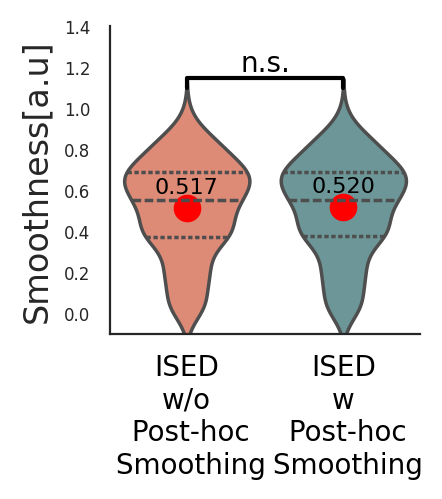

In [61]:
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   'white',
    'axes.edgecolor':   'black',
    'axes.grid':        False,
    'font.size':        14
})

df = pd.DataFrame({'ised_wt':emb_smoothness_before['ised'], 
                   'ised_w': emb_smoothness_after['ised']})

# Melt the DataFrame to make it suitable for a seaborn violin plot
df_melted = df.melt(var_name='method', value_name='Prediction')

custom_palette = {'ised_wt': '#EE7F65', 'ised_w': '#659D9E'}

sns.set_style("white")
# Create a violin plot
plt.figure(figsize=(2, 2), dpi = 200)
ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)

# 3) Nudge the mean‐text position
means = df.mean()
y_min, y_max = df_melted['Prediction'].min(), df_melted['Prediction'].max()
y_range = y_max - y_min

for i, mean in enumerate(means):
    # plot the red dot
    ax.scatter(i, mean, color='red', s=80, zorder=1)
    # place text slightly above the point
    text_y = mean + 0.05 * y_range  # 5% of full y‐range above
    ax.text(
        i, text_y,
        f'{mean:.3f}', 
        color='black',
        ha='center', 
        va='bottom',
        fontsize=8
    )

# Enhance plot
#plt.title('Distribution of Predictions for each method.')
plt.xlabel('')
ax.tick_params(labelsize=6)
plt.ylabel(r'Smoothness[a.u]', fontsize =12)
#plt.yticks([-0.1, .5])  # Set y-axis ticks to only 0 and 1
plt.ylim(-0.1, 1.4)  # Set y-axis limits to 0 and 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
new_labels = ['ISED\nw/o\n Post-hoc\n Smoothing', 'ISED\nw\n Post-hoc\n Smoothing']
ax.set_xticklabels(new_labels, fontsize=10, color = 'black')
p_value = 0.01  # Example p-value

# Choose positions (x-coordinates) for the groups you want to compare
x1, x2 = 0, 1  # x positions for the two groups
y, h, col = df_melted['Prediction'].max() + .1, 0.05, 'k'  # y position and height for the line, color

# Draw the line and the text
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * 0.5, y + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)
#plt.tight_layout()

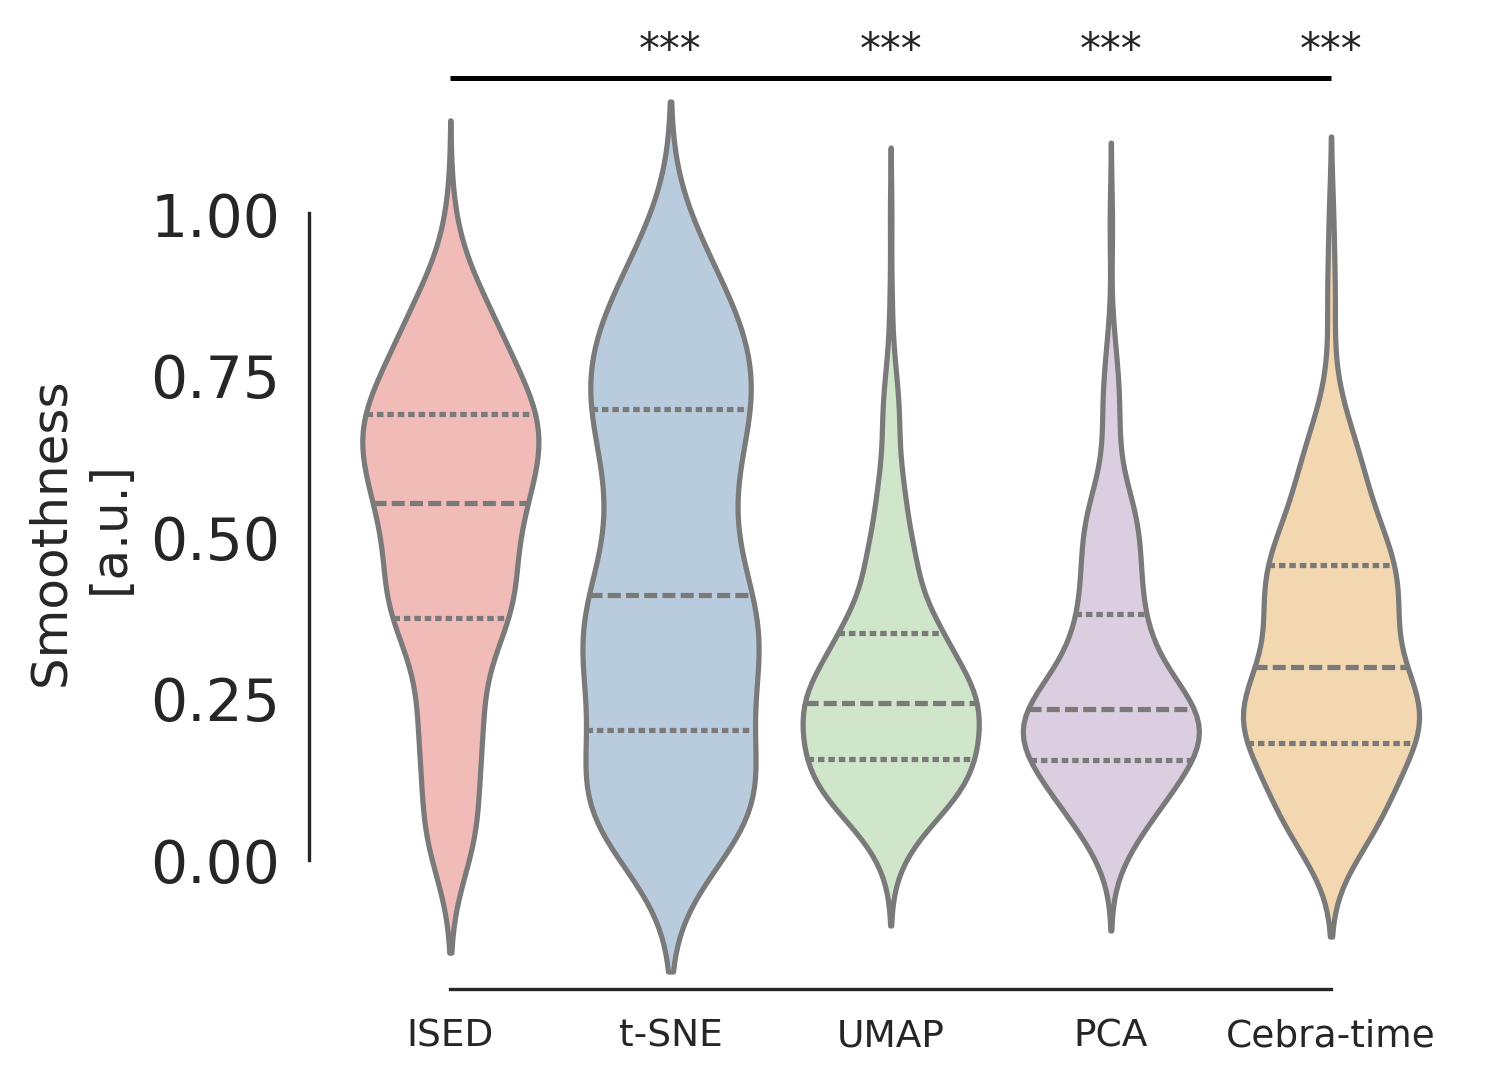

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SI = np.hstack([emb_smoothness_before['ised'].flatten(), emb_smoothness_before['tsne'].flatten(),emb_smoothness_before['umap'].flatten(),
     emb_smoothness_before['pca'].flatten(), emb_smoothness_before['cebra'].flatten()])

SI = np.asarray(SI)

methods = ['ISED'] * 364 + ['t-SNE'] * 364 + ['UMAP'] * 364 + ['PCA'] * 364 + ['Cebra-time'] * 364
df = pd.DataFrame({'Method': methods, 'BI': SI})
methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

# — Violin plot setup —
plt.figure(figsize=(5,4), dpi=300)
ax = sns.violinplot(
    x='Method', y='BI', hue='Method', data=df,
    palette="Pastel1", legend=False,
    inner='quartile', density_norm='width'
)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Smoothness \n[a.u.]', fontsize=12)
ax.tick_params(axis='x', labelsize=9)

# — Compute stars for each ISED vs. other method —
def stars(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''

star_map = {}
for method in methods_unique:
    if method == 'ISED': continue
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    _, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    star_map[method] = stars(p)

# — Single line + per-method stars —
y_min, y_max = df['BI'].min(), df['BI'].max()
h = (y_max - y_min) * 0.01
y_line = y_max + h + .2

# horizontal line from ISED (x=0) to last method (x=4)
ax.hlines(y_line, 0, len(methods_unique)-1, lw=1.2, color='black')

# place each star at its x-position
for method, x_pos in zip(methods_unique[1:], range(1, len(methods_unique))):
    sig = star_map[method]
    if not sig:
        continue
    ax.text(x_pos, y_line + h*1, sig,
            ha='center', va='bottom', fontsize=10)

# extend y-limit to fit
ax.set_ylim(-0.2, y_line + h*2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(trim=True)


In [130]:
import pandas as pd
import scipy.stats as stats

methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

results = []
for method in methods_unique[1:]:
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    u_stat, p_val = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    results.append({
        'Comparison': f'ISED vs. {method}',
        'U':    int(u_stat),
        'p':    p_val
    })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

         Comparison      U            p
     ISED vs. t-SNE  75890 6.778978e-04
      ISED vs. UMAP 105607 9.259492e-44
       ISED vs. PCA 103598 1.401319e-39
ISED vs. Cebra-time  98170 2.277971e-29


In [164]:
from scipy.stats import mannwhitneyu


df = pd.DataFrame({
    'ised_wt': emb_acc_passive['ised'],   # → shape (n_seeds,)
    'ised_w' : emb_acc_passive_after['ised']  # → shape (n_seeds,)
})

# 2) run a paired t-test across seeds
u_stat, p_val = mannwhitneyu(df['ised_wt'], df['ised_w'])
print(f"U = {u_stat:.0f}, p = {p_val:.3f}")


U = 52, p = 0.940


## Trial-wise Consistency

In [45]:
## Trial-wise consistency between passive and active 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from fastdtw import fastdtw

trial_CI = {}


for name, fname in target_embeddings.items():
    emb = np.load(fname)
    #emb = MinMaxScaler().fit_transform(emb.reshape((364*600, 2)))
    emb = emb.reshape((-1,600,2))
    #n_trial, T, F = emb.shape
    n_trial, T, F = emb.shape

    # build the 119×119 R² matrix
    sco = np.zeros((n_trial, n_trial))
    
    for i in range(n_trial):
        X = StandardScaler().fit_transform(emb[i])        # (T, F)
        for j in range(n_trial):
            if i == j:
                continue
            y = StandardScaler().fit_transform(emb[j])    # (T, F)
            model = LinearRegression()
            model.fit(X, y)
            sco[i, j] = model.score(X, y)  # R²
            

    trial_CI[name] = sco

"""

pos_trial_CI_active  = {}
for name, fname in target_embeddings.items():
    emb = np.load(fname)
    #emb = MinMaxScaler().fit_transform(emb.reshape((364*600, 2)))
    emb = emb.reshape((-1,600,2))
    #n_trial, T, F = emb.shape
    emb_active = emb[active_mask]
    n_trial, T, F = emb_active.shape

    # build the 119×119 R² matrix
    sco = np.zeros((n_trial, n_trial))
    
    for i in range(n_trial):
        X = (emb_active[i])        # (T, F)
        for j in range(n_trial):
            if i == j:
                continue
            y = (emb_active[j])    # (T, F)
            model = LinearRegression()
            model.fit(X, y)
            sco[i, j] = model.score(X, y)  # R²
            

    pos_trial_CI_active[name] = sco
    """
"""
    dtw_dist = np.zeros((n_trial, n_trial))
    for i in range(n_trial):
        for j in range(i+1, n_trial):
            dist, _ = fastdtw(emb_active[i], emb_active[j])
            dtw_dist[i, j] = dtw_dist[j, i] = dist
    
    # scale distances to [0,1] and invert → similarity
    dtw_sim = 1 - MinMaxScaler().fit_transform(dtw_dist)
    
    pos_trial_CI_active[name] = dtw_sim
"""
"""
pos_trial_CI_passive  = {}
for name, fname in target_embeddings.items():
    emb = np.load(fname)
    #emb = MinMaxScaler().fit_transform(emb.reshape((364*600, 2)))
    emb = emb.reshape((-1,600,2))
    #n_trial, T, F = emb.shape
    emb_passive = emb[passive_mask]
    n_trial, T, F = emb_passive.shape

    # build the 119×119 R² matrix
    sco = np.zeros((n_trial, n_trial))
    
    for i in range(n_trial):
        X = emb_passive[i]        # (T, F)
        for j in range(n_trial):
            if i == j:
                continue
            y = emb_passive[j]    # (T, F)
            model = LinearRegression()
            model.fit(X, y)
            sco[i, j] = model.score(X, y)  # R²
            

    pos_trial_CI_passive[name] = sco
"""


'\npos_trial_CI_passive  = {}\nfor name, fname in target_embeddings.items():\n    emb = np.load(fname)\n    #emb = MinMaxScaler().fit_transform(emb.reshape((364*600, 2)))\n    emb = emb.reshape((-1,600,2))\n    #n_trial, T, F = emb.shape\n    emb_passive = emb[passive_mask]\n    n_trial, T, F = emb_passive.shape\n\n    # build the 119×119 R² matrix\n    sco = np.zeros((n_trial, n_trial))\n    \n    for i in range(n_trial):\n        X = emb_passive[i]        # (T, F)\n        for j in range(n_trial):\n            if i == j:\n                continue\n            y = emb_passive[j]    # (T, F)\n            model = LinearRegression()\n            model.fit(X, y)\n            sco[i, j] = model.score(X, y)  # R²\n            \n\n    pos_trial_CI_passive[name] = sco\n'

In [46]:
trial_CI_reordered = {}
for name, sco in trial_CI.items():
    # compute new_order once (n_trials is same for all names)
    active_idx  = np.nonzero(active_mask)[0]
    passive_idx = np.nonzero(passive_mask)[0]
    new_order   = np.concatenate([active_idx, passive_idx])

    # reorder both rows and cols
    sco_reordered = sco[np.ix_(new_order, new_order)]
    trial_CI_reordered[name] = sco_reordered

In [47]:
len(active_idx)

193

In [48]:
split = 193

for name, mat in trial_CI_reordered.items():
    m11 = np.mean(mat[:split, :split])    # group 1 intra
    m12 = np.mean(mat[:split, split:])    # group 1→2 cross
    m22 = np.mean(mat[split:, split:])    # group 2 intra
    m21 = np.mean(mat[split:, :split])    # group 2→1 cross
    
    print(f"{name:6s}  | "
          f"intra1: {m11:.4f}  "
          f"cross12: {m12:.4f}  "
          f"intra2: {m22:.4f}  "
          f"cross21: {m21:.4f}")

ised    | intra1: 0.7272  cross12: 0.6804  intra2: 0.7752  cross21: 0.6879
tsne    | intra1: 0.8982  cross12: 0.8626  intra2: 0.8525  cross21: 0.8975
umap    | intra1: 0.4716  cross12: 0.4741  intra2: 0.4667  cross21: 0.4676
pca     | intra1: 0.6315  cross12: 0.4667  intra2: 0.5656  cross21: 0.4432
cebra   | intra1: 0.4419  cross12: 0.3882  intra2: 0.5043  cross21: 0.3705


Active:     t=8.36, p=1.29e-14
Passive:    t=17.67, p=2.46e-40


In [82]:
## Trial-wise consistency between passive and active 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from fastdtw import fastdtw

trial_CI_after = {}


for name, fname in target_embeddings.items():
    emb = np.load(fname)
    #emb = MinMaxScaler().fit_transform(emb.reshape((364*600, 2)))
    emb = emb.reshape((-1,600,2))
    #n_trial, T, F = emb.shape
    n_trial, T, F = emb.shape

    # build the 119×119 R² matrix
    sco = np.zeros((n_trial, n_trial))
    
    for i in range(n_trial):
        X = StandardScaler().fit_transform(
            post_hoc_smoothing(StandardScaler().fit_transform(emb[i])))      
        for j in range(n_trial):
            if i == j:
                continue
            y = StandardScaler().fit_transform(
            post_hoc_smoothing(StandardScaler().fit_transform(emb[j])))
            
            model = LinearRegression()
            model.fit(X, y)
            sco[i, j] = model.score(X, y)  # R²
            

    trial_CI_after[name] = sco

trial_CI_reordered_after = {}
for name, sco in trial_CI_after.items():
    # compute new_order once (n_trials is same for all names)
    active_idx  = np.nonzero(active_mask)[0]
    passive_idx = np.nonzero(passive_mask)[0]
    new_order   = np.concatenate([active_idx, passive_idx])

    # reorder both rows and cols
    sco_reordered = sco[np.ix_(new_order, new_order)]
    trial_CI_reordered_after[name] = sco_reordered
split = 193

for name, mat in trial_CI_reordered_after.items():
    m11 = np.mean(mat[:split, :split])    # group 1 intra
    m12 = np.mean(mat[:split, split:])    # group 1→2 cross
    m22 = np.mean(mat[split:, split:])    # group 2 intra
    m21 = np.mean(mat[split:, :split])    # group 2→1 cross
    
    print(f"{name:6s}  | "
          f"intra1: {m11:.4f}  "
          f"cross12: {m12:.4f}  "
          f"intra2: {m22:.4f}  "
          f"cross21: {m21:.4f}")

ised    | intra1: 0.7273  cross12: 0.6804  intra2: 0.7753  cross21: 0.6879
tsne    | intra1: 0.8982  cross12: 0.8627  intra2: 0.8525  cross21: 0.8976
umap    | intra1: 0.4716  cross12: 0.4742  intra2: 0.4668  cross21: 0.4677
pca     | intra1: 0.6315  cross12: 0.4667  intra2: 0.5656  cross21: 0.4432
cebra   | intra1: 0.4419  cross12: 0.3882  intra2: 0.5043  cross21: 0.3705


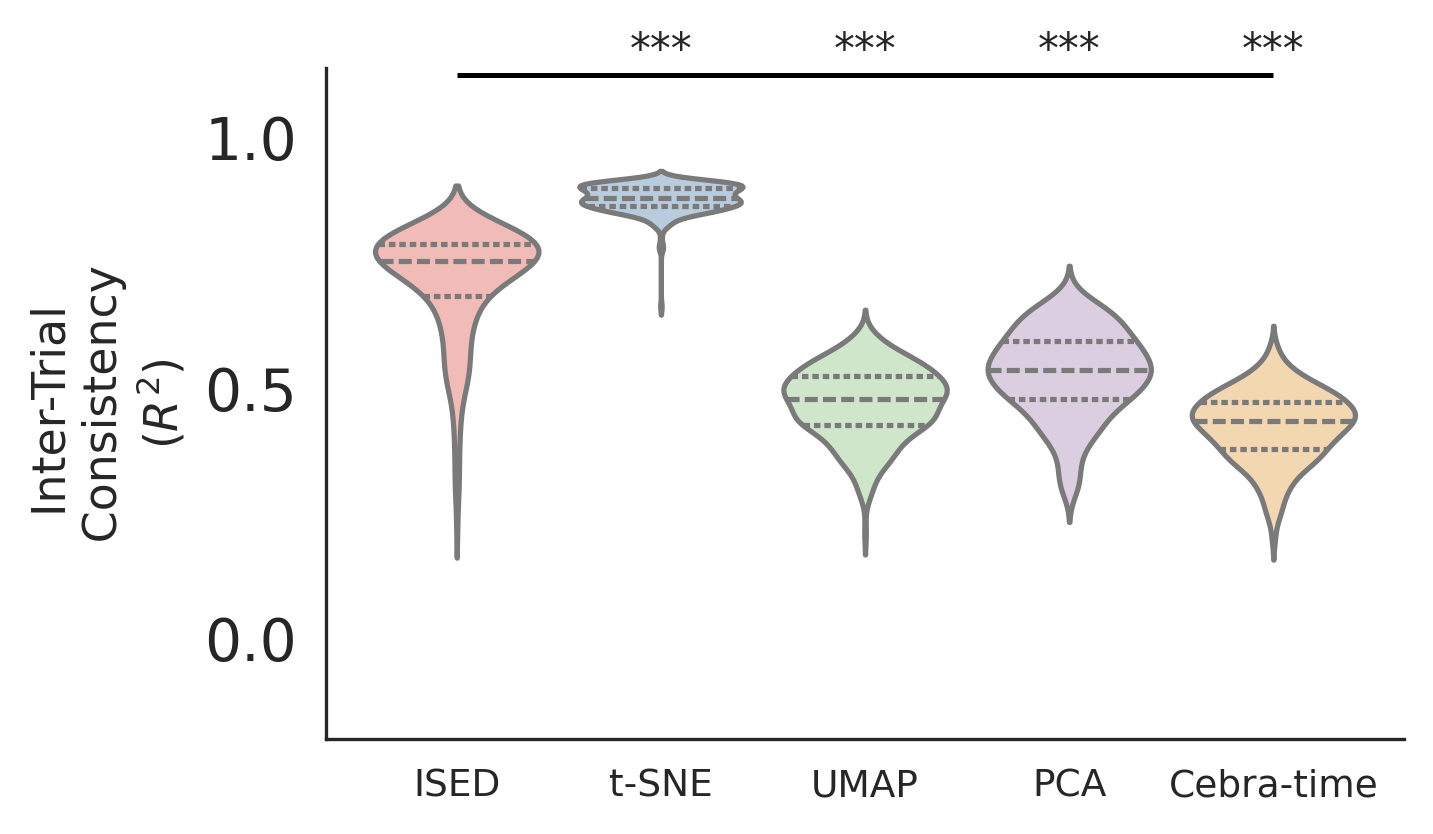

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SI = np.hstack([trial_CI['ised'].mean(axis = 1), trial_CI['tsne'].mean(axis = 1),trial_CI['umap'].mean(axis = 1),
     trial_CI['pca'].mean(axis = 1), trial_CI['cebra'].mean(axis = 1)])

SI = np.asarray(SI)

methods = ['ISED'] * (364) + ['t-SNE'] * (364) + ['UMAP'] * (364) + ['PCA'] * (364) + ['Cebra-time'] * (364)
df = pd.DataFrame({'Method': methods, 'BI': SI})
methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

# — Violin plot setup —
plt.figure(figsize=(5,3), dpi=300)
ax = sns.violinplot(
    x='Method', y='BI', hue='Method', data=df,
    palette="Pastel1", legend=False,
    inner='quartile', density_norm='width'
)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Inter-Trial \n Consistency \n($R^2$)', fontsize=11)
ax.tick_params(axis='x', labelsize=9)

# — Compute stars for each ISED vs. other method —
def stars(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''

star_map = {}
for method in methods_unique:
    if method == 'ISED': continue
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    _, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    star_map[method] = stars(p)

# — Single line + per-method stars —
y_min, y_max = df['BI'].min(), df['BI'].max()
h = (y_max - y_min) * 0.01
y_line = y_max + h + .2

# horizontal line from ISED (x=0) to last method (x=4)
ax.hlines(y_line, 0, len(methods_unique)-1, lw=1.2, color='black')

# place each star at its x-position
for method, x_pos in zip(methods_unique[1:], range(1, len(methods_unique))):
    sig = star_map[method]
    if not sig:
        continue
    ax.text(x_pos, y_line + h*1, sig,
            ha='center', va='bottom', fontsize=10)

# extend y-limit to fit
ax.set_ylim(-0.2, y_line + h*2)
plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
import scipy.stats as stats

methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

results = []
for method in methods_unique[1:]:
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    u_stat, p_val = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    results.append({
        'Comparison': f'ISED vs. {method}',
        'U':    int(u_stat),
        'p':    p_val
    })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

         Comparison      U             p
     ISED vs. t-SNE    823 1.158141e-117
      ISED vs. UMAP 125503  7.240018e-97
       ISED vs. PCA 119935  7.370035e-80
ISED vs. Cebra-time 128056 3.187575e-105


/tmp/ipykernel_3902195/3431014969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/3431014969.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/3431014969.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=10, color = 'black')


Text(0.5, 0.9874483739817504, 'n.s.')

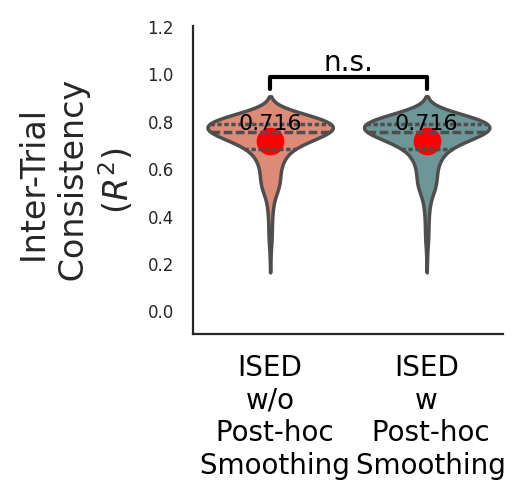

In [86]:
df = pd.DataFrame({'ised_wt':trial_CI['ised'].mean(axis=1), 
                   'ised_w': trial_CI_after['ised'].mean(axis=1)})

# Melt the DataFrame to make it suitable for a seaborn violin plot
df_melted = df.melt(var_name='method', value_name='Prediction')

custom_palette = {'ised_wt': '#EE7F65', 'ised_w': '#659D9E'}

sns.set_style("white")
# Create a violin plot
plt.figure(figsize=(2, 2), dpi = 200)
ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)

# 3) Nudge the mean‐text position
means = df.mean()
y_min, y_max = df_melted['Prediction'].min(), df_melted['Prediction'].max()
y_range = y_max - y_min

for i, mean in enumerate(means):
    # plot the red dot
    ax.scatter(i, mean, color='red', s=80, zorder=1)
    # place text slightly above the point
    text_y = mean + 0.05 * y_range  # 5% of full y‐range above
    ax.text(
        i, text_y,
        f'{mean:.3f}', 
        color='black',
        ha='center', 
        va='bottom',
        fontsize=8
    )

# Enhance plot
#plt.title('Distribution of Predictions for each method.')
plt.xlabel('')
ax.tick_params(labelsize=6)
plt.ylabel('Inter-Trial \n Consistency \n($R^2$)', fontsize =12)
#plt.yticks([-0.1, .5])  # Set y-axis ticks to only 0 and 1
plt.ylim(-0.1, 1.2)  # Set y-axis limits to 0 and 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
new_labels = ['ISED\nw/o\n Post-hoc\n Smoothing', 'ISED\nw\n Post-hoc\n Smoothing']
ax.set_xticklabels(new_labels, fontsize=10, color = 'black')
p_value = 0.01  # Example p-value

# Choose positions (x-coordinates) for the groups you want to compare
x1, x2 = 0, 1  # x positions for the two groups
y, h, col = df_melted['Prediction'].max() + .1, 0.05, 'k'  # y position and height for the line, color

# Draw the line and the text
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * 0.5, y + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)

##  Behavior Decodability


In [87]:
## 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedShuffleSplit, cross_val_score, ShuffleSplit

# Trial-wise 

emb_BI_before = {}

for name, fname in target_embeddings.items():
    # 1) load your embeddings: shape (n_trials, T, F)
    emb = np.load(fname)
    n_trials, T, F = emb.shape

    # 2) load & reshape behavior so that behav[i] is the i-th trial, shape (T,) or (T, D)
    behav_flat = monkey_target_all.data['pos'][:]  
    behav = behav_flat.reshape((n_trials, T, -1))

    trial_scores = np.zeros(n_trials, dtype=float)
    scaler = StandardScaler()

    for i in range(n_trials):
        X_i = (emb[i])   # shape (T, F)
        y_i = behav[i]                       # shape (T,) or (T, D)

        model = LinearRegression()
        model.fit(X_i, y_i)
        # .score returns the R² (averaged across outputs if multi‐dimensional y)
        trial_scores[i] = model.score(X_i, y_i)

    emb_BI_before[name] = trial_scores

# print mean ± std across trials
for name, scores in emb_BI_before.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

ised      :  0.781 ± 0.141
tsne      :  0.695 ± 0.254
umap      :  0.548 ± 0.230
pca       :  0.710 ± 0.188
cebra     :  0.514 ± 0.221


In [89]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedShuffleSplit, cross_val_score, ShuffleSplit


emb_BI_after = {}
for name, fname in target_embeddings.items():
    emb = np.load(fname)
    n_trials, T, F = emb.shape

    behav_flat = monkey_target_all.data['pos'][:]  
    behav = behav_flat.reshape((n_trials, T, -1))

    trial_scores = np.zeros(n_trials, dtype=float)
    scaler = StandardScaler()

    for i in range(n_trials):
        X_i = scaler.fit_transform(post_hoc_smoothing(scaler.fit_transform(emb[i])))   # shape (T, F)
        y_i = behav[i]                       # shape (T,) or (T, D)

        model = LinearRegression()
        model.fit(X_i, y_i)
        # .score returns the R² (averaged across outputs if multi‐dimensional y)
        trial_scores[i] = model.score(X_i, y_i)

    emb_BI_after[name] = trial_scores
# print mean ± std across trials
for name, scores in emb_BI_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

ised      :  0.781 ± 0.141
tsne      :  0.695 ± 0.254
umap      :  0.548 ± 0.230
pca       :  0.710 ± 0.188
cebra     :  0.514 ± 0.221


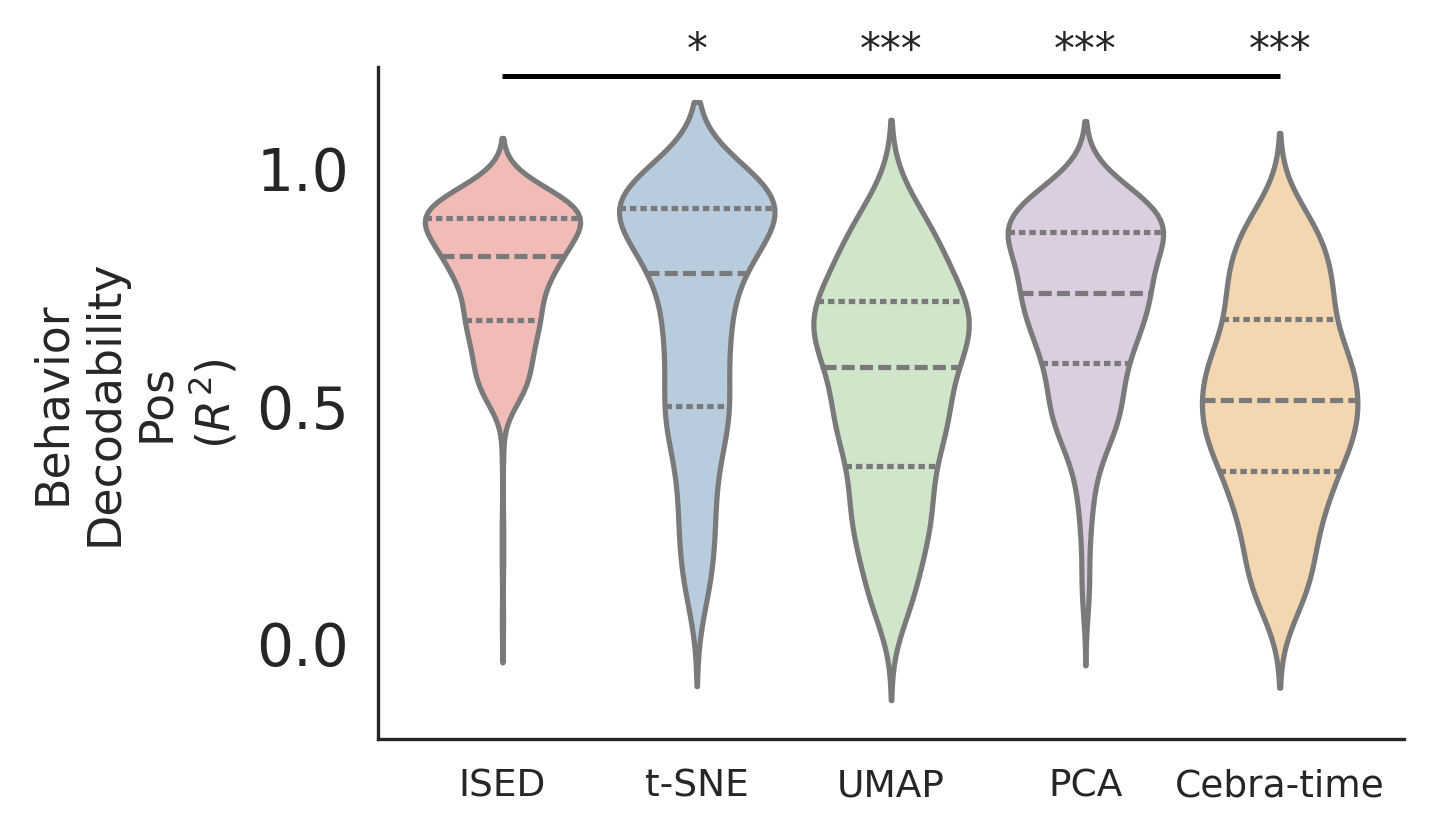

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SI = np.hstack([emb_BI_before['ised'], emb_BI_before['tsne'],emb_BI_before['umap'],
     emb_BI_before['pca'], emb_BI_before['cebra']])

SI = np.asarray(SI)

methods = ['ISED'] * (364) + ['t-SNE'] * (364) + ['UMAP'] * (364) + ['PCA'] * (364) + ['Cebra-time'] * (364)
df = pd.DataFrame({'Method': methods, 'BI': SI})
methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

# — Violin plot setup —
plt.figure(figsize=(5,3), dpi=300)
ax = sns.violinplot(
    x='Method', y='BI', hue='Method', data=df,
    palette="Pastel1", legend=False,
    inner='quartile', density_norm='width'
)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Behavior\nDecodability\nPos\n($R^2$)', fontsize=11)
ax.tick_params(axis='x', labelsize=9)

# — Compute stars for each ISED vs. other method —
def stars(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''

star_map = {}
for method in methods_unique:
    if method == 'ISED': continue
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    _, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    star_map[method] = stars(p)

# — Single line + per-method stars —
y_min, y_max = df['BI'].min(), df['BI'].max()
h = (y_max - y_min) * 0.01
y_line = y_max + h + .2

# horizontal line from ISED (x=0) to last method (x=4)
ax.hlines(y_line, 0, len(methods_unique)-1, lw=1.2, color='black')

# place each star at its x-position
for method, x_pos in zip(methods_unique[1:], range(1, len(methods_unique))):
    sig = star_map[method]
    if not sig:
        continue
    ax.text(x_pos, y_line + h*1, sig,
            ha='center', va='bottom', fontsize=10)

# extend y-limit to fit
ax.set_ylim(-0.2, y_line + h*2)
plt.tight_layout()
plt.show()

In [91]:
import pandas as pd
import scipy.stats as stats

methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

results = []
for method in methods_unique[1:]:
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    u_stat, p_val = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    results.append({
        'Comparison': f'ISED vs. {method}',
        'U':    int(u_stat),
        'p':    p_val
    })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

         Comparison      U            p
     ISED vs. t-SNE  72991 1.747553e-02
      ISED vs. UMAP 106399 1.816371e-45
       ISED vs. PCA  80554 4.599740e-07
ISED vs. Cebra-time 111689 9.795853e-58


/tmp/ipykernel_3902195/360793701.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/360793701.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/360793701.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=10, color = 'black')


Text(0.5, 1.1279992820499585, 'n.s.')

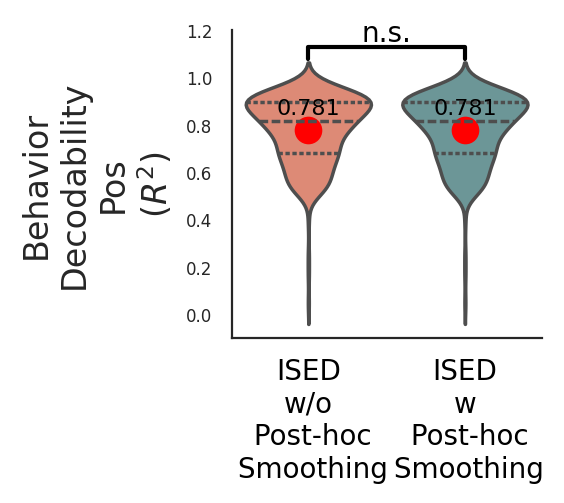

In [93]:
df = pd.DataFrame({'ised_wt':emb_BI_before['ised'], 
                   'ised_w': emb_BI_after['ised']})

# Melt the DataFrame to make it suitable for a seaborn violin plot
df_melted = df.melt(var_name='method', value_name='Prediction')

custom_palette = {'ised_wt': '#EE7F65', 'ised_w': '#659D9E'}

sns.set_style("white")
# Create a violin plot
plt.figure(figsize=(2, 2), dpi = 200)
ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)

# 3) Nudge the mean‐text position
means = df.mean()
y_min, y_max = df_melted['Prediction'].min(), df_melted['Prediction'].max()
y_range = y_max - y_min

for i, mean in enumerate(means):
    # plot the red dot
    ax.scatter(i, mean, color='red', s=80, zorder=1)
    # place text slightly above the point
    text_y = mean + 0.05 * y_range  # 5% of full y‐range above
    ax.text(
        i, text_y,
        f'{mean:.3f}', 
        color='black',
        ha='center', 
        va='bottom',
        fontsize=8
    )

# Enhance plot
#plt.title('Distribution of Predictions for each method.')
plt.xlabel('')
ax.tick_params(labelsize=6)
plt.ylabel('Behavior\nDecodability\nPos\n($R^2$)', fontsize =12)
#plt.yticks([-0.1, .5])  # Set y-axis ticks to only 0 and 1
plt.ylim(-0.1, 1.2)  # Set y-axis limits to 0 and 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
new_labels = ['ISED\nw/o\n Post-hoc\n Smoothing', 'ISED\nw\n Post-hoc\n Smoothing']
ax.set_xticklabels(new_labels, fontsize=10, color = 'black')
p_value = 0.01  # Example p-value

# Choose positions (x-coordinates) for the groups you want to compare
x1, x2 = 0, 1  # x positions for the two groups
y, h, col = df_melted['Prediction'].max() + .1, 0.05, 'k'  # y position and height for the line, color

# Draw the line and the text
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * 0.5, y + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)

## Trial-type decodability 

In [114]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

emb_acc_passive = {}
for name, fname in target_embeddings.items():
    # 1) load & flatten embeddings → (n_trials*T, F)
    emb = np.load(fname)
    emb = [StandardScaler().fit_transform(emb)for emb in emb]
    X = np.concatenate([trial for trial in emb], axis=0)
    #X = np.asarray(emb).mean(axis = 1)

    # 2) pull out your discrete states, flatten to (n_trials*T,)
    behav = np.asarray(monkey_target_all.passive)
    #behav = (monkey_target_all.data['movement_dir']).astype(int)

    # 3) define a linear classifier
    clf = LogisticRegression(
        solver='lbfgs',
        max_iter=5000,
        class_weight='balanced'   # optional if your classes are imbalanced
    )

    # 4) cross‐val accuracy
    scores = cross_val_score(
        clf, X, behav,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    emb_acc_passive[name] = scores
emb_acc_passive

{'ised': array([0.49125458, 0.50233516, 0.49313187, 0.4860348 , 0.48841575,
        0.4974359 , 0.50100733, 0.49546703, 0.4989011 , 0.49638278]),
 'tsne': array([0.48978938, 0.49981685, 0.5021978 , 0.49294872, 0.49326923,
        0.50009158, 0.5       , 0.50196886, 0.49148352, 0.49203297]),
 'umap': array([0.50265568, 0.50096154, 0.49162088, 0.49262821, 0.50123626,
        0.49459707, 0.50608974, 0.49372711, 0.49867216, 0.49619963]),
 'pca': array([0.47554945, 0.50260989, 0.53021978, 0.44363553, 0.50228938,
        0.51410256, 0.54862637, 0.4904304 , 0.44001832, 0.5220696 ]),
 'cebra': array([0.50421245, 0.50549451, 0.50315934, 0.50837912, 0.48521062,
        0.50453297, 0.49358974, 0.4978022 , 0.49061355, 0.50723443])}

(600, 2)

In [123]:
emb_acc_passive_after = {}
for name, fname in target_embeddings.items():
    # 1) load & flatten embeddings → (n_trials*T, F)
    emb = np.load(fname)
    emb = [StandardScaler().fit_transform(emb)for emb in emb]
    X = np.concatenate([trial for trial in emb], axis=0)
    X = post_hoc_smoothing(X)
    # 2) pull out your discrete states, flatten to (n_trials*T,)
    behav = np.asarray(monkey_target_all.passive)

    # 3) define a linear classifier
    clf = LogisticRegression(
        solver='lbfgs',
        max_iter=5000,
        class_weight='balanced'   # optional if your classes are imbalanced
    )

    # 4) cross‐val accuracy
    scores = cross_val_score(
        clf,X, behav,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    emb_acc_passive_after[name] = scores

In [124]:
emb_acc_passive_after

{'ised': array([0.48919414, 0.5025641 , 0.49001832, 0.48608059, 0.49331502,
        0.49638278, 0.49711538, 0.49578755, 0.49913004, 0.49619963]),
 'tsne': array([0.48992674, 0.49839744, 0.50224359, 0.49230769, 0.49157509,
        0.49972527, 0.49967949, 0.50457875, 0.4915293 , 0.49491758]),
 'umap': array([0.50389194, 0.50215201, 0.49326923, 0.49441392, 0.50265568,
        0.49514652, 0.50480769, 0.49203297, 0.49514652, 0.49569597]),
 'pca': array([0.47449634, 0.50343407, 0.50732601, 0.45819597, 0.52197802,
        0.51675824, 0.55077839, 0.49459707, 0.44423077, 0.52051282]),
 'cebra': array([0.50494505, 0.49038462, 0.49450549, 0.49372711, 0.48598901,
        0.48795788, 0.49986264, 0.49061355, 0.50650183, 0.49990842])}

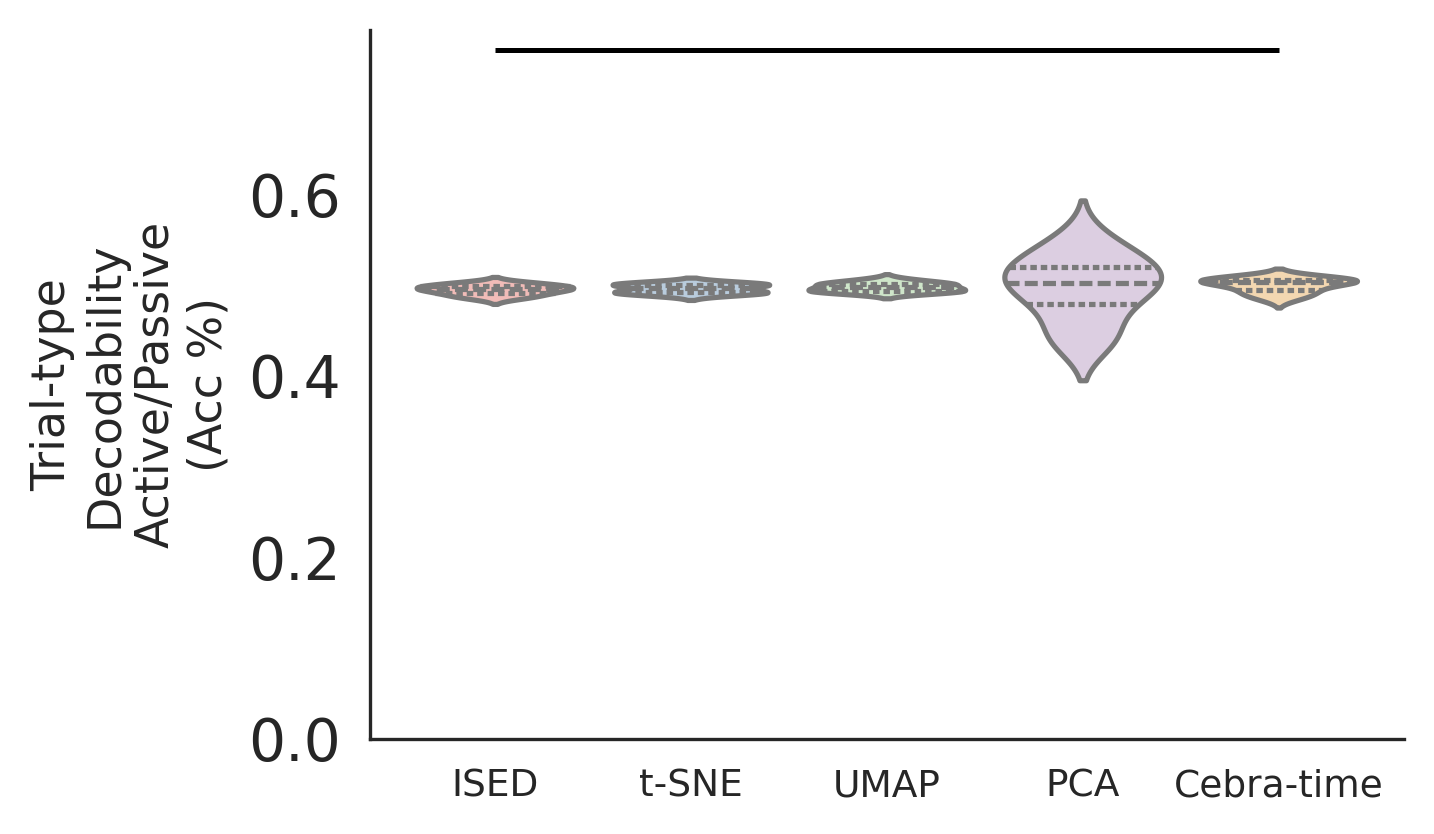

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

SI = np.hstack([emb_acc_passive['ised'], emb_acc_passive['tsne'],
                emb_acc_passive['umap'],
     emb_acc_passive['pca'], emb_acc_passive['cebra']])

SI = np.asarray(SI)

methods = ['ISED'] * (10) + ['t-SNE'] * (10) + ['UMAP'] * (10) + ['PCA'] * (10) + ['Cebra-time'] * (10)
df = pd.DataFrame({'Method': methods, 'BI': SI})
methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

# — Violin plot setup —
plt.figure(figsize=(5,3), dpi=300)
ax = sns.violinplot(
    x='Method', y='BI', hue='Method', data=df,
    palette="Pastel1", legend=False,
    inner='quartile', density_norm='width'
)
sns.despine(ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Trial-type\nDecodability\nActive/Passive\n(Acc %)', fontsize=11)
ax.tick_params(axis='x', labelsize=9)

# — Compute stars for each ISED vs. other method —
def stars(p):
    return '***' if p<0.001 else '**' if p<0.01 else '*' if p<0.05 else ''

star_map = {}
for method in methods_unique:
    if method == 'ISED': continue
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    _, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    star_map[method] = stars(p)

# — Single line + per-method stars —
y_min, y_max = df['BI'].min(), df['BI'].max()
h = (y_max - y_min) * 0.1
y_line = y_max + h + .2

# horizontal line from ISED (x=0) to last method (x=4)
ax.hlines(y_line, 0, len(methods_unique)-1, lw=1.2, color='black')

# place each star at its x-position
for method, x_pos in zip(methods_unique[1:], range(1, len(methods_unique))):
    sig = star_map[method]
    if not sig:
        continue
    ax.text(x_pos, y_line + h*1, sig,
            ha='center', va='bottom', fontsize=10)

# extend y-limit to fit
ax.set_ylim(-0., y_line + h*2)
plt.tight_layout()
plt.show()

In [122]:
import pandas as pd
import scipy.stats as stats

methods_unique = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

results = []
for method in methods_unique[1:]:
    g1 = df.loc[df['Method']=='ISED','BI']
    g2 = df.loc[df['Method']==method,'BI']
    u_stat, p_val = stats.mannwhitneyu(g1, g2, alternative='two-sided')
    results.append({
        'Comparison': f'ISED vs. {method}',
        'U':    int(u_stat),
        'p':    p_val
    })

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

         Comparison  U        p
     ISED vs. t-SNE 43 0.623176
      ISED vs. UMAP 37 0.344704
       ISED vs. PCA 39 0.427355
ISED vs. Cebra-time 27 0.088973


/tmp/ipykernel_3902195/1377284952.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/1377284952.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)
/tmp/ipykernel_3902195/1377284952.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=10, color = 'black')


Text(0.5, 0.6525641025641026, 'n.s.')

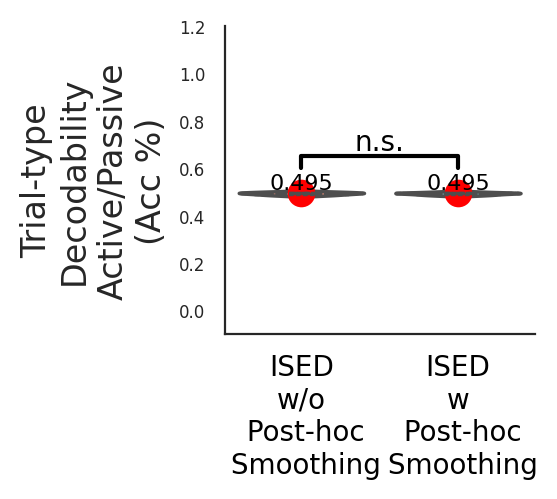

In [126]:
df = pd.DataFrame({'ised_wt':emb_acc_passive['ised'], 
                   'ised_w': emb_acc_passive_after['ised']})

# Melt the DataFrame to make it suitable for a seaborn violin plot
df_melted = df.melt(var_name='method', value_name='Prediction')

custom_palette = {'ised_wt': '#EE7F65', 'ised_w': '#659D9E'}

sns.set_style("white")
# Create a violin plot
plt.figure(figsize=(2, 2), dpi = 200)
ax = sns.violinplot(x='method', y='Prediction', data=df_melted, scale='count', inner='quartile', palette=custom_palette)

# 3) Nudge the mean‐text position
means = df.mean()
y_min, y_max = df_melted['Prediction'].min(), df_melted['Prediction'].max()
y_range = y_max - y_min

for i, mean in enumerate(means):
    # plot the red dot
    ax.scatter(i, mean, color='red', s=80, zorder=1)
    # place text slightly above the point
    text_y = mean + 0.05 * y_range  # 5% of full y‐range above
    ax.text(
        i, text_y,
        f'{mean:.3f}', 
        color='black',
        ha='center', 
        va='bottom',
        fontsize=8
    )

# Enhance plot
#plt.title('Distribution of Predictions for each method.')
plt.xlabel('')
ax.tick_params(labelsize=6)
plt.ylabel('Trial-type\nDecodability\nActive/Passive\n(Acc %)', fontsize =12)
#plt.yticks([-0.1, .5])  # Set y-axis ticks to only 0 and 1
plt.ylim(-0.1, 1.2)  # Set y-axis limits to 0 and 1

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
new_labels = ['ISED\nw/o\n Post-hoc\n Smoothing', 'ISED\nw\n Post-hoc\n Smoothing']
ax.set_xticklabels(new_labels, fontsize=10, color = 'black')
p_value = 0.01  # Example p-value

# Choose positions (x-coordinates) for the groups you want to compare
x1, x2 = 0, 1  # x positions for the two groups
y, h, col = df_melted['Prediction'].max() + .1, 0.05, 'k'  # y position and height for the line, color

# Draw the line and the text
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * 0.5, y + h, "n.s.", ha='center', va='bottom', color=col, fontsize=10)

## Plot the trajectories divided by Trial types

In [15]:
def plot_monkey_neural_traj(ax, trials, dirs, colors, labels, title):
    cmap       = plt.get_cmap('tab10')
    colors     = [cmap(i) for i in range(8)]
    deg_labels = [f'{i*45}°' for i in range(8)]

    ax.set_title(title, fontsize=16, pad=8)
    ax.set_facecolor('white')
    
    for i in range(8):
        mask     = (dirs == i)
        trials_i = trials[mask]
        if not trials_i.size:
            continue
        
        # mean trajectory
        mean_traj = np.mean(trials_i, axis=0)
        
        # plot the mean line
        ax.plot(mean_traj[:,0], mean_traj[:,1],
                color=colors[i],
                linewidth=2.5,
                zorder=2,
                label=labels[i])
        
        # start marker 
        ax.scatter(mean_traj[0,0], mean_traj[0,1],
                   marker='s',
                   s=60,
                   facecolors=colors[i],
                   edgecolors=colors[i],
                   linewidth=1.5,
                   zorder=3)
        
        # end marker 
        ax.scatter(mean_traj[-1,0], mean_traj[-1,1],
                   marker='^',
                   s=60,
                   facecolors=colors[i],
                   edgecolors='black',
                   linewidth=1,
                   zorder=3)
    
    # clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    #ax.legend(title='Direction', fontsize=12, title_fontsize=13, loc='upper right')



def plot_monkey_neural_traj_3d(ax, trials, dirs, colors, labels, title):
        # ─── 2) Prepare colors & labels ──────────────────────────────────────────
    cmap       = plt.get_cmap('tab10')
    colors     = [cmap(i) for i in range(8)]
    deg_labels = [f'{i*45}°' for i in range(8)]
    
    # ─── 3) Create figure ───────────────────────────────────────────────────
    fig = plt.figure(figsize=(9, 7), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    """
    Plots the mean 3D neural trajectories for different directions.
    """
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_facecolor('white')
    
    for i in range(8):
        mask     = (dirs == i)
        trials_i = trials[mask]
        if not trials_i.size:
            continue
        
        # Mean trajectory
        mean_traj = np.mean(trials_i, axis=0)
        
        # Plot the mean line in 3D
        ax.plot(mean_traj[:,0], mean_traj[:,1], mean_traj[:,2],
                color=colors[i],
                linewidth=2.5,
                zorder=2,
                label=labels[i])
        
        # Start marker (3D)
        ax.scatter(mean_traj[0,0], mean_traj[0,1], mean_traj[0,2],
                   marker='s',
                   s=60,
                   facecolors=colors[i],
                   edgecolors=colors[i],
                   linewidth=1.5,
                   zorder=3)
        
        # End marker (3D)
        ax.scatter(mean_traj[-1,0], mean_traj[-1,1], mean_traj[-1,2],
                   marker='^',
                   s=60,
                   facecolors=colors[i],
                   edgecolors='black',
                   linewidth=1,
                   zorder=3)
    
    # Clean up axes for 3D
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.grid(False)
    
    ax.legend(title='Direction', fontsize=10, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1))


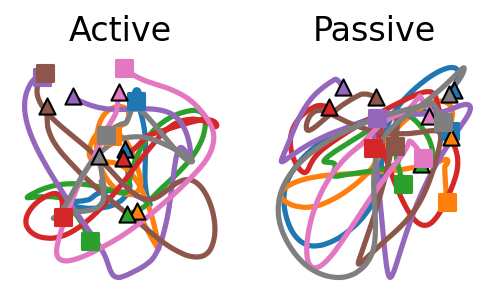

In [23]:
import matplotlib.pyplot as plt

scaled_emb = np.asarray([MinMaxScaler().fit_transform(emb) for emb in np.load(target_embeddings['cebra'])])

passive = np.asarray(monkey_target_all.data['passive'])
movement_dir = np.asarray(monkey_target_all.data['movement_dir'])

active_mask  = (passive == 0)
passive_mask = (passive == 1)
active_dirs  = movement_dir[active_mask][:]
passive_dirs = movement_dir[passive_mask][:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
cmap       = plt.get_cmap('tab10')
colors     = [cmap(i) for i in range(8)]
deg_labels = [f'{i*45}°' for i in range(8)]

#plot_monkey_neural_traj(ax1, scaled_emb[active_mask][:80],  
 #                       active_dirs,  colors, deg_labels, 'Active')
#plot_monkey_neural_traj(ax1, scaled_emb[active_mask][:80],  
 #                       active_dirs,  colors, deg_labels, 'Active')

plot_monkey_neural_traj(ax1, scaled_emb[active_mask][:],  
                        active_dirs,  colors, deg_labels, 'Active')
plot_monkey_neural_traj(ax2, scaled_emb[passive_mask][:],  
                        passive_dirs,  colors, deg_labels, 'Passive')


(-0.5, 999.5, 64.5, -0.5)

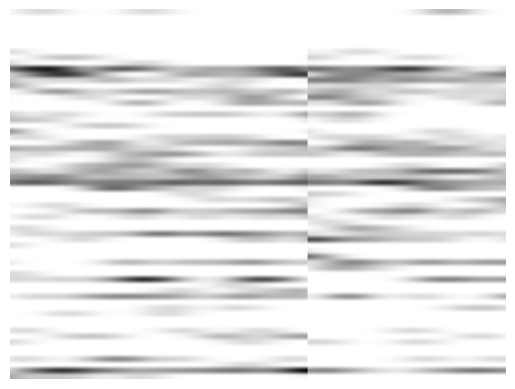

In [838]:
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(111)
ax.imshow(monkey_target_all.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
ax.grid(False)
ax.axis('off')

In [172]:
np.load(target_embeddings['cebra']).reshape((-1,600,2))[active_mask].shape

(193, 600, 2)

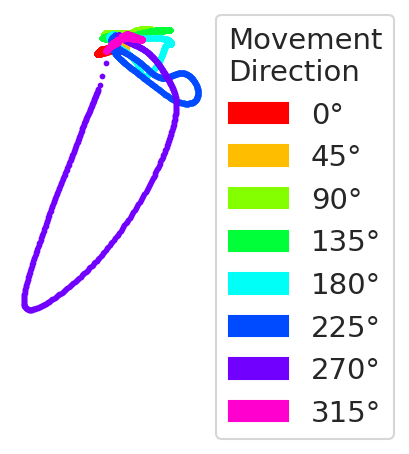

In [824]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(3, 3), dpi=150)
ax = plt.subplot(111)

# precompute colors and legend handles
n_dirs = 8
colors = [plt.cm.hsv(i / n_dirs) for i in range(n_dirs)]
handles = []
for i, col in enumerate(colors):
    angle = int(360 / n_dirs * i)
    handles.append(mpatches.Patch(color=col, label=f"{angle}°"))

# plot each direction
emb_all = np.load(target_embeddings['cebra']).reshape((364*600, 2))
for i, col in enumerate(colors):
    # boolean mask for all time‐points in trials of direction i
    mask = (monkey_target_all.discrete_index == i)
    # reshape & average per time‐step
    trial_avg = emb_all[mask].reshape(-1, 600, 2).mean(axis=0)
    ax.scatter(trial_avg[:, 0],
               trial_avg[:, 1],
               color=col,
               s=3)

ax.axis('off')
ax.legend(handles=handles,
          title="Movement\nDirection",
          bbox_to_anchor=(1.05, 1),
          loc='upper left',
          borderaxespad=0.)

plt.tight_layout()
plt.show()

In [658]:

for name, scores in emb_smoothness_before.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 
for name, scores in trial_CI.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 
for name, scores in emb_BI_before.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 

for name, scores in emb_acc_passive.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")


ori       :  0.132 ± 0.338
ised      :  0.517 ± 0.234
tsne      :  0.448 ± 0.281
umap      :  0.270 ± 0.166
pca       :  0.281 ± 0.178
cebra     :  0.323 ± 0.193
===****===
ori       :  0.525 ± 0.289
ised      :  0.716 ± 0.213
tsne      :  0.879 ± 0.130
umap      :  0.470 ± 0.192
pca       :  0.529 ± 0.203
cebra     :  0.425 ± 0.193
===****===
ori       :  0.218 ± 0.200
ised      :  0.781 ± 0.141
tsne      :  0.695 ± 0.254
umap      :  0.548 ± 0.230
pca       :  0.710 ± 0.188
cebra     :  0.514 ± 0.221
===****===
ori       :  0.508 ± 0.031
ised      :  0.498 ± 0.005
tsne      :  0.497 ± 0.005
umap      :  0.500 ± 0.003
pca       :  0.494 ± 0.034
cebra     :  0.493 ± 0.006


In [657]:

for name, scores in emb_smoothness_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 
for name, scores in trial_CI_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 
for name, scores in emb_BI_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")

print ('===****===') 

for name, scores in emb_acc_passive_after.items():
    print(f"{name:10s}:  {scores.mean():.3f} ± {scores.std():.3f}")


ori       :  0.132 ± 0.338
ised      :  0.520 ± 0.234
tsne      :  0.455 ± 0.266
umap      :  0.246 ± 0.146
pca       :  0.280 ± 0.178
cebra     :  0.322 ± 0.193
===****===
ori       :  0.526 ± 0.289
ised      :  0.726 ± 0.206
tsne      :  0.880 ± 0.130
umap      :  0.473 ± 0.192
pca       :  0.531 ± 0.204
cebra     :  0.430 ± 0.194
===****===
ori       :  0.219 ± 0.201
ised      :  0.788 ± 0.136
tsne      :  0.696 ± 0.255
umap      :  0.549 ± 0.230
pca       :  0.711 ± 0.188
cebra     :  0.518 ± 0.221
===****===
ori       :  0.486 ± 0.023
ised      :  0.498 ± 0.004
tsne      :  0.505 ± 0.009
umap      :  0.503 ± 0.004
pca       :  0.514 ± 0.008
cebra     :  0.495 ± 0.004


In [ ]:
ori       :  0.132 ± 0.338
ised      :  0.517 ± 0.234
tsne      :  0.448 ± 0.281
umap      :  0.270 ± 0.166
pca       :  0.281 ± 0.178
cebra     :  0.323 ± 0.193
===****===
ori       :  0.525 ± 0.289
ised      :  0.716 ± 0.213
tsne      :  0.879 ± 0.130
umap      :  0.470 ± 0.192
pca       :  0.529 ± 0.203
cebra     :  0.425 ± 0.193
===****===
ori       :  0.218 ± 0.200
ised      :  0.781 ± 0.141
tsne      :  0.695 ± 0.254
umap      :  0.548 ± 0.230
pca       :  0.710 ± 0.188
cebra     :  0.514 ± 0.221
===****===
ori       :  0.508 ± 0.031
ised      :  0.498 ± 0.005
tsne      :  0.497 ± 0.005
umap      :  0.500 ± 0.003
pca       :  0.494 ± 0.034
cebra     :  0.493 ± 0.006

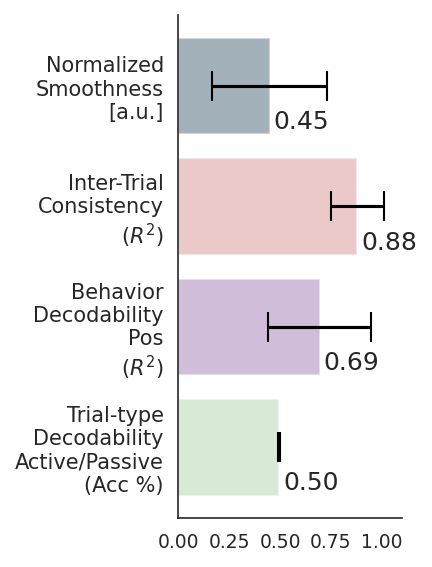

In [128]:
## Results plotting 
# Organize data into lists
labels = [
    "Normalized\nSmoothness\n[a.u.]",
    "Inter-Trial\nConsistency\n($R^2$)",
    "Behavior\nDecodability\nPos\n($R^2$)",
    "Trial-type\nDecodability\nActive/Passive\n(Acc %)"
]

ised_mean = [0.517, 0.716, 0.781, 0.498]
ised_std = [0.234, 0.213, 0.141, 0.005]

tsne_mean = [0.448, 0.879, 0.695, 0.497]
tsne_std = [0.281, 0.130, 0.254, 0.005]

umap_mean = [0.270, 0.470, 0.470, 0.500]
umap_std = [0.166, 0.192, 0.192, 0.003]

pca_mean = [0.281, 0.529, 0.710, 0.494]
pca_std = [0.178, 0.203, 0.188, 0.034]

cebra_mean = [0.323, 0.425, 0.514, 0.493]
cebra_std = [0.193, 0.193, 0.221, 0.006]

# Positions for the bars
y_pos = np.arange(len(labels))

# Create the figure and axes; adjust figsize/dpi for publication
fig, ax = plt.subplots(figsize=(3, 4.), dpi=150)

# Make a horizontal bar chart with error bars
bars = ax.barh(
    y_pos,
    tsne_mean,
    xerr=tsne_std, # remove this if you do not have error bars
    height = 0.8,
    align='center',
    alpha=0.5,
    capsize=7,             # length of the error bar caps
    color=['#486478','#DA9594', '#A17DB4','#b3d6ad','#e1bb82']  # pick any colors you like
)

# Invert the y-axis so the top bar is first
ax.invert_yaxis()

# Set y-axis tick labels
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=10)

# Label the x-axis and optionally set limits if your values are between 0 and 1
#ax.set_xlabel("Value", fontsize=8)
ax.set_xlim(0, 1.1)  # adjust if your values exceed 1 or start below 0

# Add a title if desired
#ax.set_title("Comparison of Metrics", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_ticks = np.linspace(0, 1, 5)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks], fontsize=9)


# Optionally draw a vertical line for 'chance' or a reference
# ax.axvline(x=0.5, color='k', linestyle='--', linewidth=1)

# Tidy up the layout
for bar, mean in zip(bars, tsne_mean):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height()
    ax.text(
        x + 0.02, y-0.1,
        f"{mean:.2f}",
        va='center', ha='left',
        fontsize=12
    )
plt.tight_layout()




In [671]:
SI = np.hstack([emb_smoothness_before['ised'].flatten(), emb_smoothness_before['tsne'].flatten(),emb_smoothness_before['umap'].flatten(),
     emb_smoothness_before['pca'].flatten(), emb_smoothness_before['cebra'].flatten()])

SI = np.asarray(SI)
SI.shape

(1820,)

In [174]:
## After smoothing operation comparison:

In [815]:

numpy_before =  np.expand_dims(np.array(list(emb_smoothness_before.values()))[1:].ravel(), axis = 1)
numpy_after = np.expand_dims(np.array(list(emb_smoothness_after.values()))[1:].ravel(),axis = 1)

In [786]:
numpy_before = np.expand_dims(np.diagonal(np.array(list(trial_CI.values()))[1:], axis1=1, axis2=2).ravel(), axis = 1)
numpy_after = np.expand_dims(np.diagonal(np.array(list(trial_CI_after.values()))[1:], axis1=1, axis2=2).ravel(), axis = 1)

In [816]:
numpy_after.shape

(1820, 1)

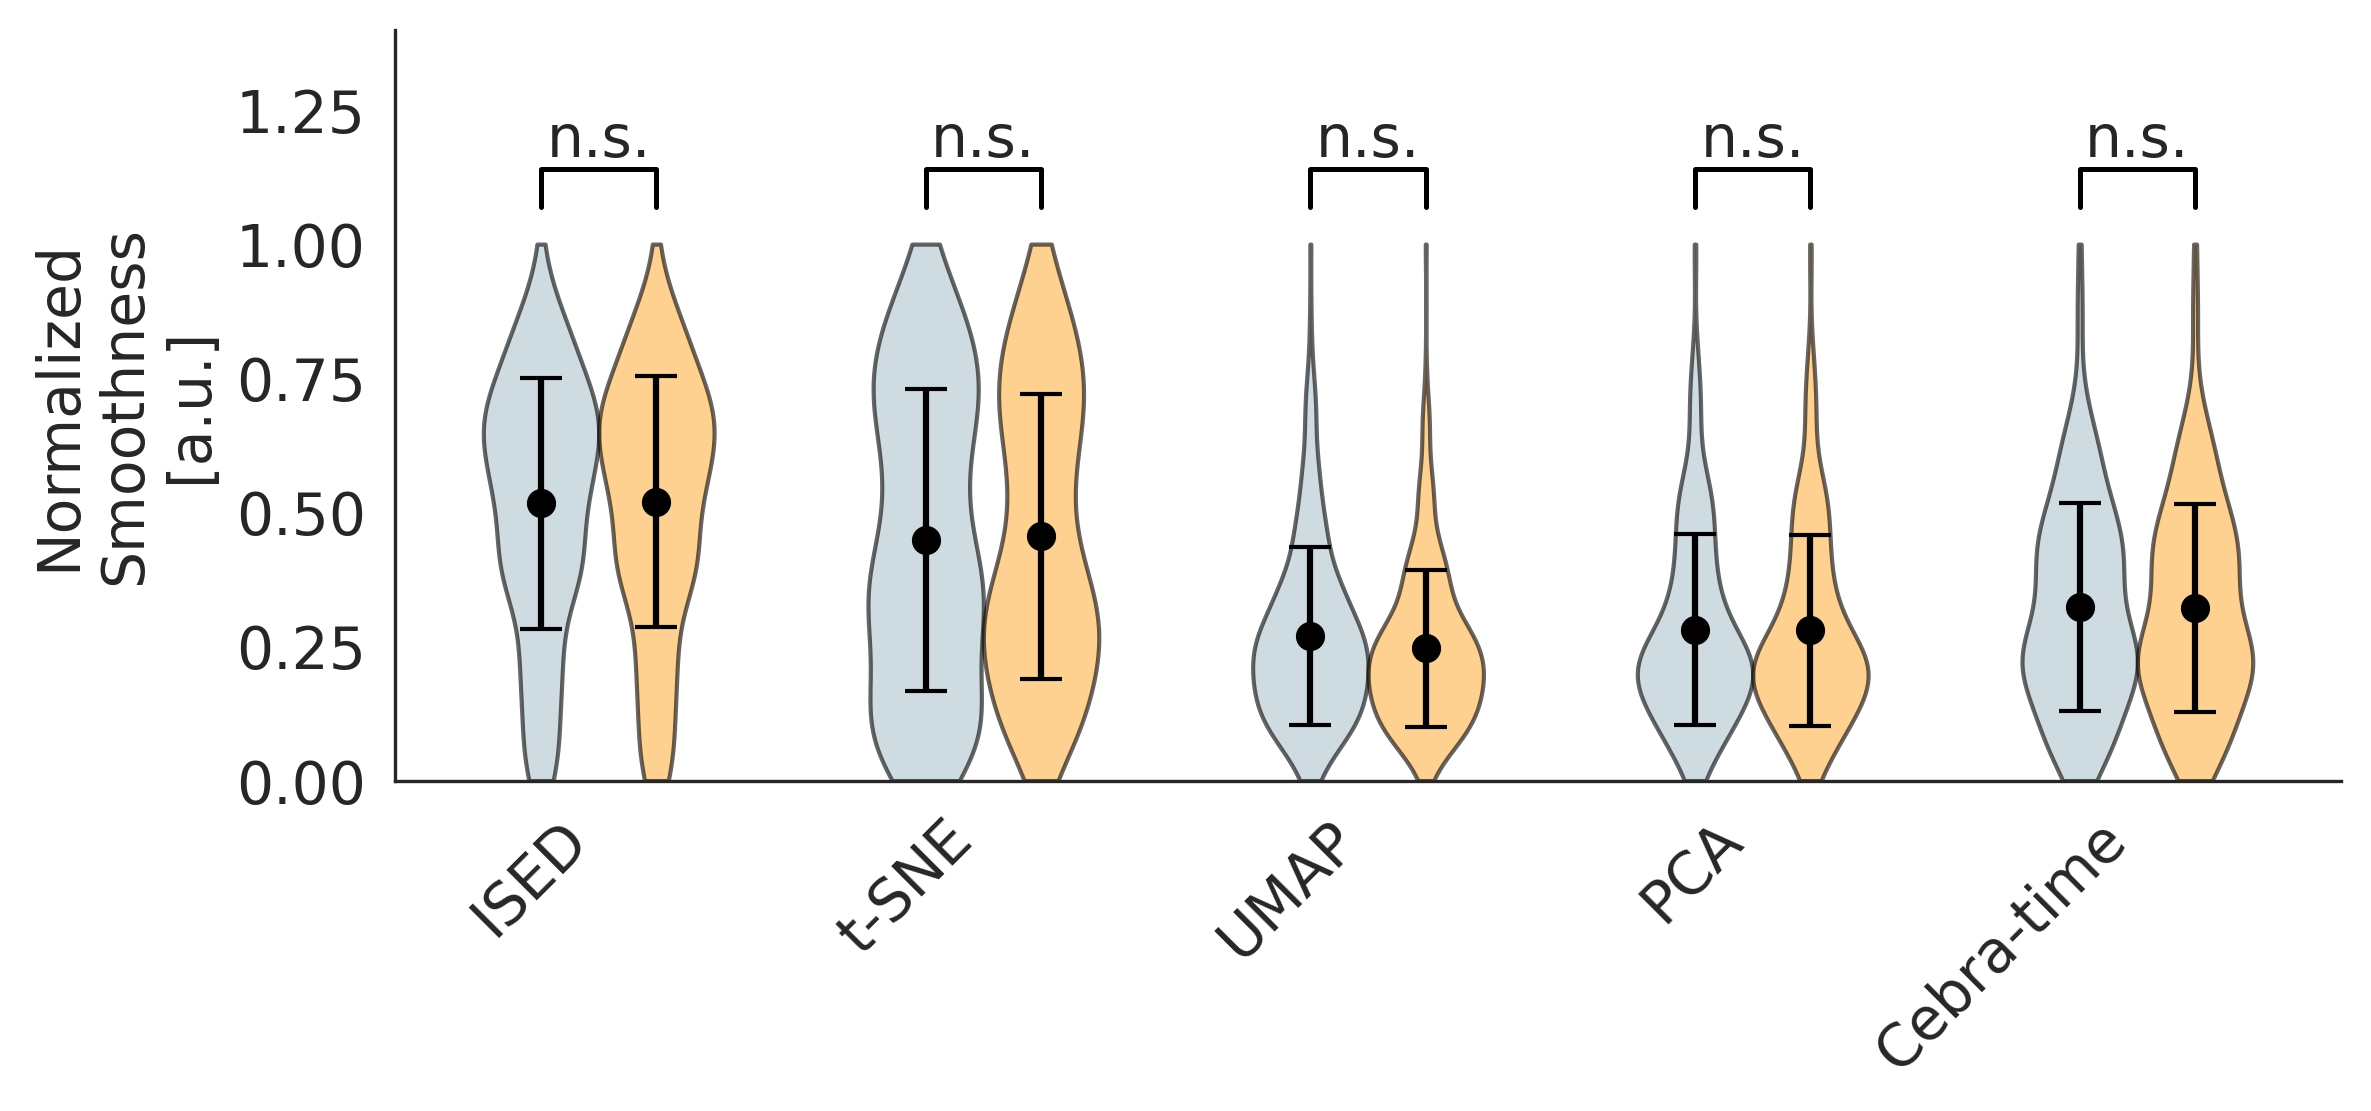

In [822]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel  # paired t-test
import seaborn as sns

labels = [
    "Normalized\nSmoothness\n[a.u.]",
    "Inter-Trial\nConsistency\n($R^2$)",
    "Behavior\nDecodability\nPos\n($R^2$)",
    "Trial-type\nDecodability\nActive/Passive\n(Acc %)"
]

methods     = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']
y_labels    = ['Normalized\nSmoothness\n[a.u.]']

def significance_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'n.s.'

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor':   'white',
    'font.size':        14
})

n_methods = len(methods)
n_trials  = numpy_before.shape[0] // n_methods
x         = np.arange(n_methods)
w         = 0.3

for m_idx, y_label in enumerate(y_labels):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    n_trials = 364
    # split out before/after for this metric
    data_b = [numpy_before[i*n_trials:(i+1)*n_trials, m_idx] for i in range(n_methods)]
    data_a = [numpy_after [i*n_trials:(i+1)*n_trials, m_idx] for i in range(n_methods)]

    # violin + errorbar for ALL panels
    vb = ax.violinplot(data_b, positions=x - w/2, widths=w, showextrema=False)
    va = ax.violinplot(data_a, positions=x + w/2, widths=w, showextrema=False)
    for pc in vb['bodies']:
        pc.set_facecolor('#AEC6CF'); pc.set_edgecolor('black'); pc.set_alpha(0.6)
    for pc in va['bodies']:
        pc.set_facecolor('#FFB347'); pc.set_edgecolor('black'); pc.set_alpha(0.6)

    means_b = [d.mean() for d in data_b]; stds_b = [d.std() for d in data_b]
    means_a = [d.mean() for d in data_a]; stds_a = [d.std() for d in data_a]
    ax.errorbar(x - w/2, means_b, yerr=stds_b, fmt='o', color='k', capsize=5)
    ax.errorbar(x + w/2, means_a, yerr=stds_a, fmt='o', color='k', capsize=5)

    ax.set_xticks(x)
    ax.set_ylim(0,1.4)
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.set_ylabel(y_label)

    # paired t-test for each method
    for i in range(n_methods):
        before = data_b[i]
        after  = data_a[i]
        # ensure there are no NaNs and lengths match
        mask = ~np.isnan(before) & ~np.isnan(after)
        if mask.sum() < n_trials*2:
            pval = 1.0
        else:
            _, pval = ttest_rel(before[mask], after[mask])
        star = significance_stars(pval)

        # draw the little bar + star
        x1, x2 = x[i] - w/2, x[i] + w/2
        y_max = max(before.max(), after.max())
        h = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
        y = y_max + h
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], 'k-', lw=1.2)
        ax.text((x1+x2)/2, y+h, star, ha='center', va='bottom', fontsize=14)

       #print(f"{methods[i]} (panel {m_idx}): p = {pval:.4f} → {star}")

    sns.despine(trim=False)
    plt.tight_layout()

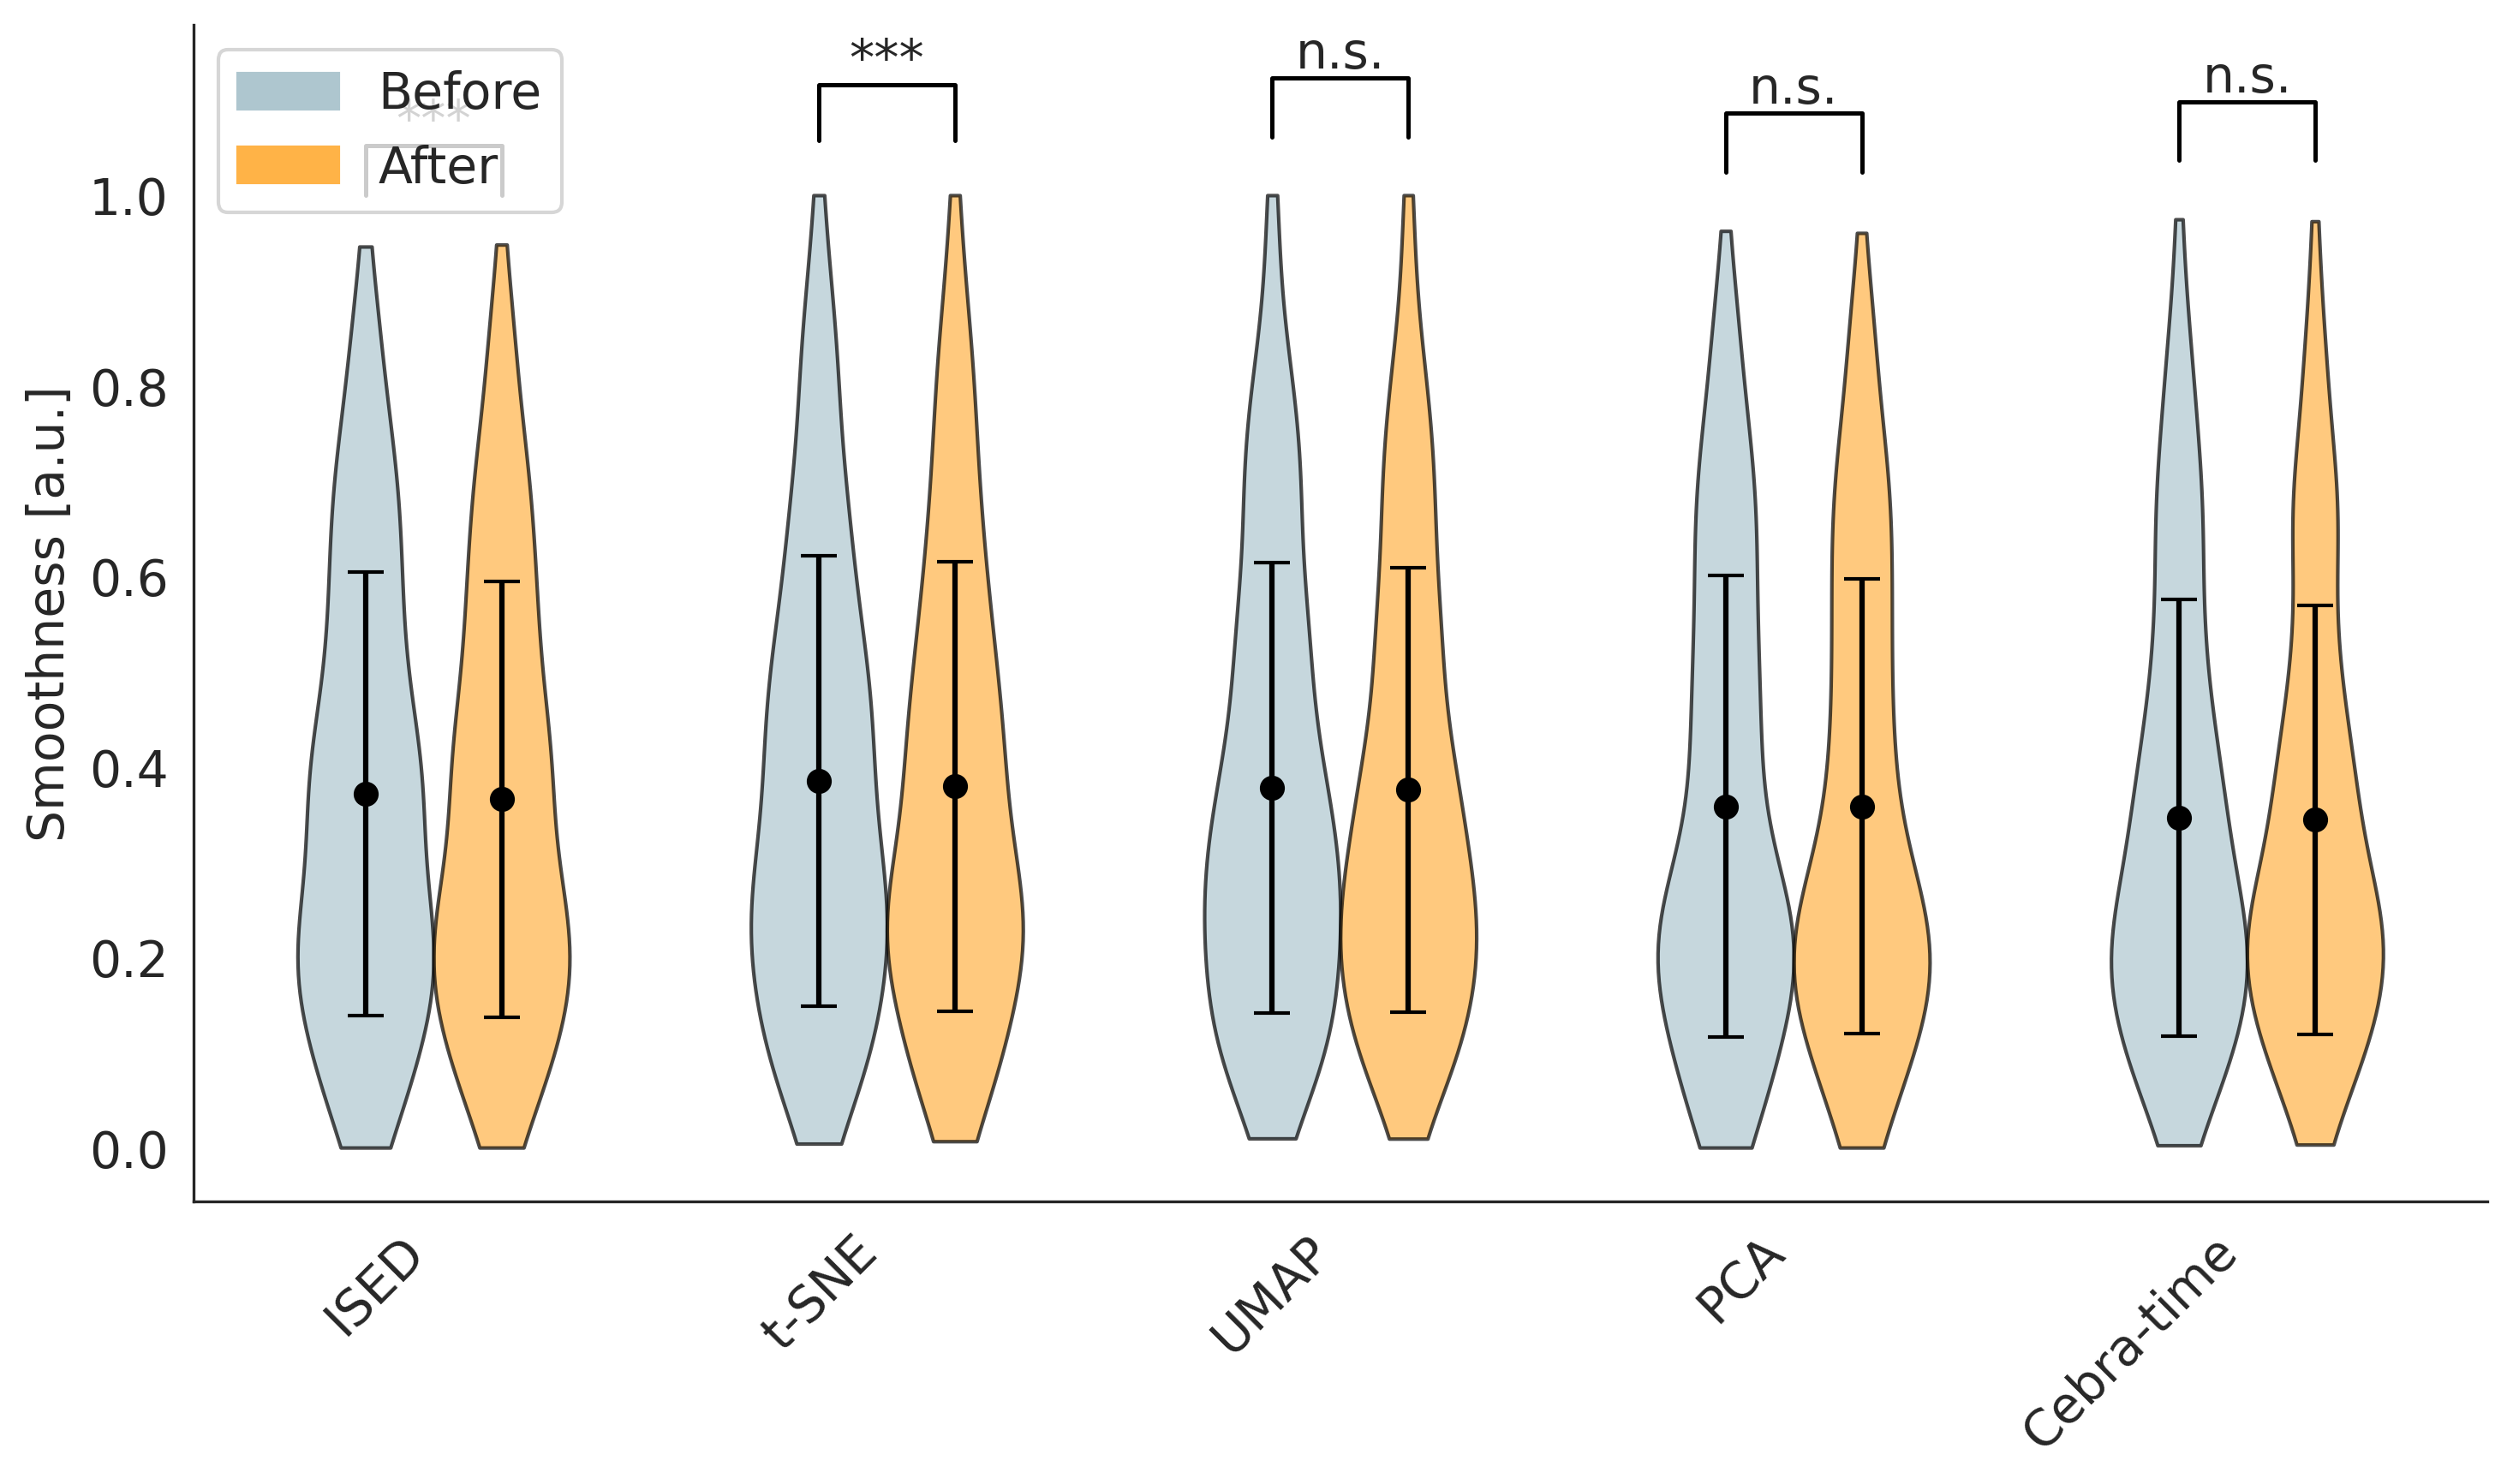

In [762]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel  # paired t-test
import seaborn as sns
import matplotlib.patches as mpatches

# ——— your data ———
# numpy_before, numpy_after: each shape (1820, 1)
before_vals = numpy_before.ravel()
after_vals  = numpy_after.ravel()

methods  = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']
n_methods = len(methods)
n_trials  = 364   # trials per method

# helper for stars
def significance_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'n.s.'

# ——— split into lists of length-364 ———
data_b = [before_vals[i*n_trials:(i+1)*n_trials] 
          for i in range(n_methods)]
data_a = [after_vals [i*n_trials:(i+1)*n_trials] 
          for i in range(n_methods)]

# ——— plotting setup ———
sns.set_style("white")
plt.rcParams.update({'font.size': 14})
x = np.arange(n_methods)
w = 0.3

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for i in range(n_methods):
    # violins
    vb = ax.violinplot(data_b[i], positions=[x[i]-w/2], widths=w, showextrema=False)
    va = ax.violinplot(data_a[i], positions=[x[i]+w/2], widths=w, showextrema=False)
    for pc in vb['bodies']:
        pc.set_facecolor('#AEC6CF'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
    for pc in va['bodies']:
        pc.set_facecolor('#FFB347'); pc.set_edgecolor('black'); pc.set_alpha(0.7)

    # error‐bars
    m_b, s_b = data_b[i].mean(), data_b[i].std()
    m_a, s_a = data_a[i].mean(), data_a[i].std()
    ax.errorbar(x[i]-w/2, m_b, yerr=s_b, fmt='o', color='k', capsize=5)
    ax.errorbar(x[i]+w/2, m_a, yerr=s_a, fmt='o', color='k', capsize=5)

    # paired t‐test + star
    mask = ~np.isnan(data_b[i]) & ~np.isnan(data_a[i])
    _, pval = ttest_rel(data_b[i][mask], data_a[i][mask]) if mask.sum()>1 else (None, 1.0)
    star = significance_stars(pval)

    # draw connector + star
    y0 = max(data_b[i].max(), data_a[i].max())
    h  = 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    y  = y0 + h
    ax.plot([x[i]-w/2, x[i]-w/2, x[i]+w/2, x[i]+w/2],
            [y, y+h, y+h, y], 'k-', lw=1.2)
    ax.text(x[i], y+h, star, ha='center', va='bottom', fontsize=14)

# ——— finalize ———
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_ylabel('Smoothness [a.u.]')

# legend
legend_handles = [
    mpatches.Patch(color='#AEC6CF', label='Before'),
    mpatches.Patch(color='#FFB347', label='After')
]
ax.legend(handles=legend_handles, loc='upper left')

sns.despine(trim=False)
plt.tight_layout()
plt.show()


In [839]:
## Correlation between smoothness and other characters


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def general_scatter_plot(df, xcol, ycol, title, ylabel , poly_degree=None):
    plt.figure(figsize=(6, 4), dpi=300)
    sns.set_style("white")
    ax = plt.gca()

    # prepare colors by Method
    unique_methods = sorted(df['Method'].unique())
    palette = dict(zip(unique_methods, 
                       sns.color_palette("husl", n_colors=len(unique_methods))))

    plot_kwargs = dict(
        data=df, x=xcol, y=ycol,
        hue='Method', palette=palette,
        s=80, edgecolor='black', ax=ax
    )

    # only style by Dataset if it exists
    if 'Dataset' in df.columns:
        unique_ds = sorted(df['Dataset'].unique())
        markers   = dict(zip(unique_ds, ['o','s','^','D'][:len(unique_ds)]))
        plot_kwargs['style']   = 'Dataset'
        plot_kwargs['markers'] = markers

    sns.scatterplot(**plot_kwargs)

    # extract arrays
    x_vals = df[xcol].dropna().values
    y_vals = df[ycol].dropna().values

    if len(x_vals) > 1 and len(y_vals) > 1:
        # --- Linear fit ---
        slope, intercept, r_val, _, _ = linregress(x_vals, y_vals)
        r2_lin = r_val**2
        xx = np.linspace(x_vals.min(), x_vals.max(), 100)
        ax.plot(xx, intercept + slope*xx, '-k', lw=1.5, label='Linear fit')
        ax.text(0.05, 0.95, f'Linear $R^2={r2_lin:.2f}$',
                transform=ax.transAxes, ha='left', va='top',
                fontsize=12, color='black')

        # --- Polynomial fit if requested ---
        if poly_degree and poly_degree > 1:
            coeffs = np.polyfit(x_vals, y_vals, poly_degree)
            y_poly = np.polyval(coeffs, x_vals)
            ss_res = np.sum((y_vals - y_poly)**2)
            ss_tot = np.sum((y_vals - y_vals.mean())**2)
            r2_poly = 1 - ss_res/ss_tot
            # plot the polynomial curve
            x_fit = np.linspace(x_vals.min(), x_vals.max(), 100)
            y_fit = np.polyval(coeffs, x_fit)
            ax.plot(x_fit, y_fit, '--k', lw=1.5, label=f'Poly{poly_degree} fit')
            ax.text(0.05, 0.88, f'Nonlin $R^2={r2_poly:.2f}$',
                    transform=ax.transAxes, ha='left', va='top',
                    fontsize=12, color='black')

    # labels & legend
    ax.set_xlabel('Smoothness [a.u.]', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, pad=6)
    sns.despine(trim=True)
    ax.legend(bbox_to_anchor=(1, 0.42), loc='upper right', frameon=False, fontsize=8)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [ ]:
method_wise_SI =  (np.expand_dims(np.array(list(emb_smoothness_before.values()))[1:].ravel(), axis = 1)).reshape(-1, 364).mean(axis = 1)

method_wise_CI = (np.expand_dims(np.array(list(trial_CI.values()))[1:].ravel(), axis = 1)).reshape(-1, 364*364).mean(axis = 1)


method_wise_BI = (np.expand_dims(np.array(list(emb_BI_before.values()))[1:].ravel(), axis = 1)).reshape(-1, 364).mean(axis = 1)


method_wise_DI = (np.expand_dims(np.array(list(emb_acc_passive.values()))[1:].ravel(), axis = 1)).reshape(-1, 10).mean(axis = 1)

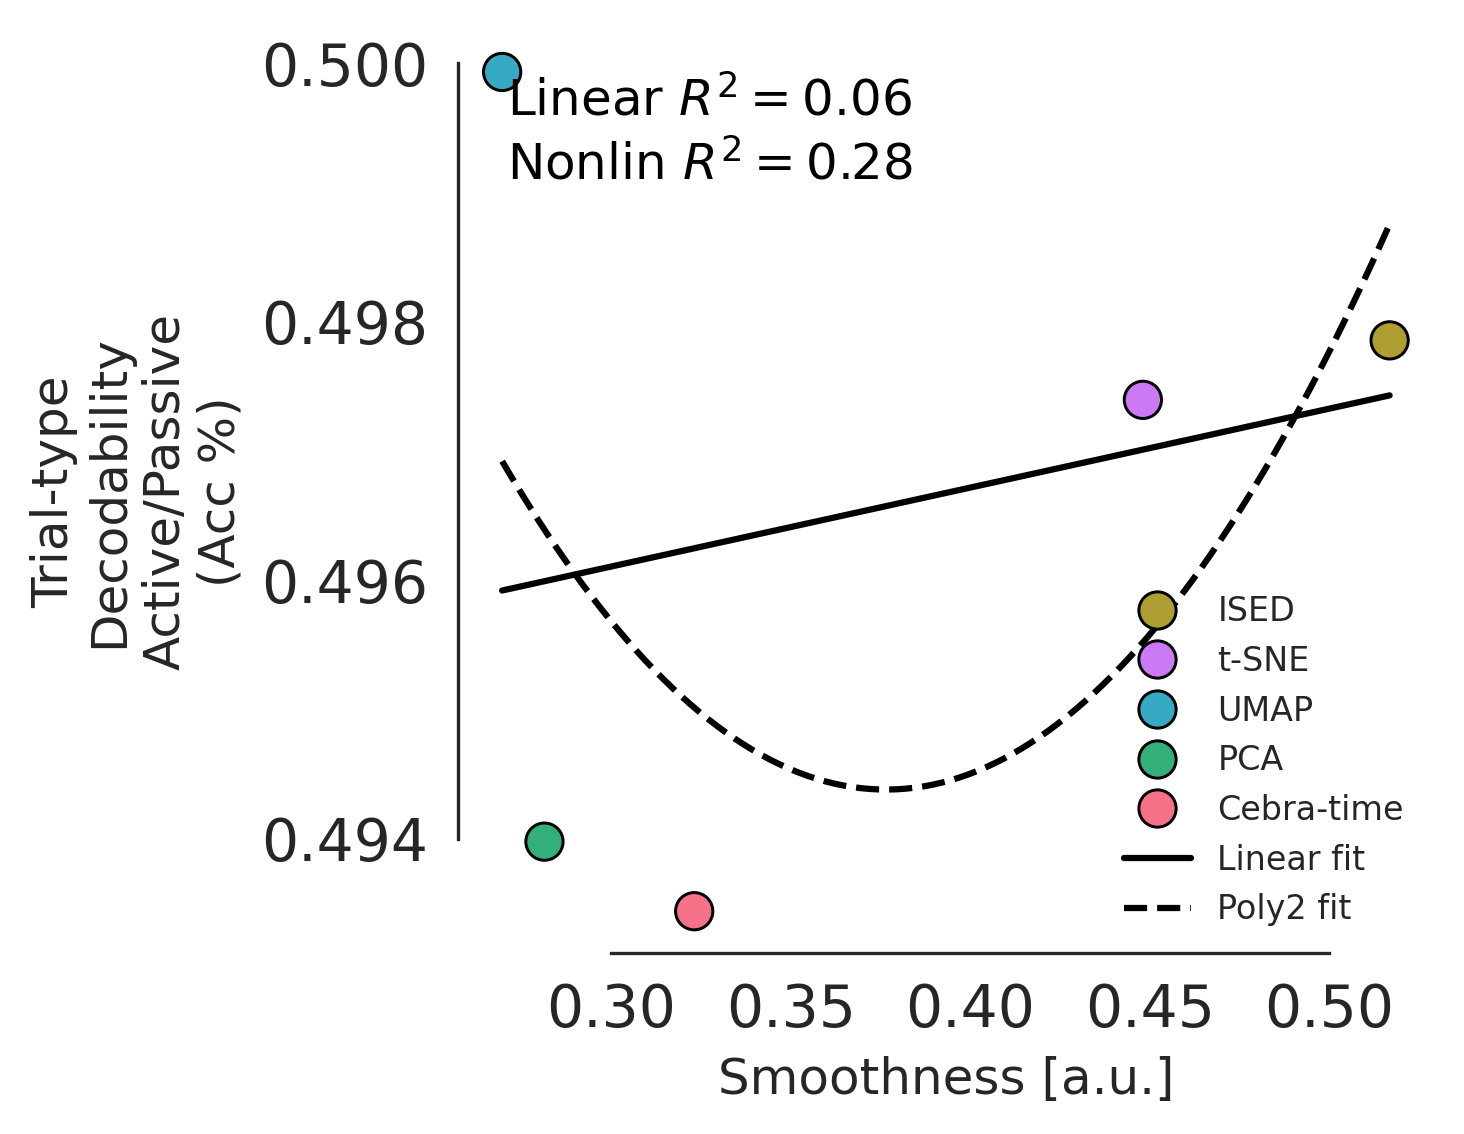

In [854]:
labels = [
    "Normalized\nSmoothness\n[a.u.]",
    "Inter-Trial\nConsistency\n($R^2$)",
    "Behavior\nDecodability\nPos\n($R^2$)",
    "Trial-type\nDecodability\nActive/Passive\n(Acc %)"
]

methods = ['ISED', 't-SNE', 'UMAP', 'PCA', 'Cebra-time']

df_nb = pd.DataFrame({
    'Method':             methods,
    'Smoothness [a.u.]':  method_wise_SI,
    'Inter-Trial\nConsistency\n($R^2$)':  method_wise_CI,
    'Behavior\nDecodability\nPos\n($R^2$)':method_wise_BI,
    'Trial-type':method_wise_DI,
    
})

general_scatter_plot(
    df_nb,
    xcol='Smoothness [a.u.]',
    ycol='Trial-type',
    title='',
    poly_degree=2,
    ylabel = 'Trial-type\nDecodability\nActive/Passive\n(Acc %)'
    
)
